# 0.0 IMPORTS

In [2]:
import math
import datetime
import numpy as np
import pandas as pd
import inflection
import seaborn as sns
import xgboost as xgb
import pickle
import warnings
import json
import requests


from matplotlib import pyplot as plt
from IPython.core.display import HTML
from IPython.display import Image
from scipy import stats as ss
from boruta import BorutaPy

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor

warnings.filterwarnings('ignore')

## 0.1 Helper Functions

In [3]:
def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print('\nKFold Number: {}'.format(k))
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        #training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model
        # lr = LinearRegression().fit(xtraining, ytraining)
        m = model.fit(xtraining, ytraining)

        # prediction
        # yhat_lr = lr.predict(xvalidation)
        yhat = m.predict(xvalidation)

        # performance
        # lr_result = ml_error('Linear Regression', np.expm1(yvalidation), np.expm1(yhat_lr))
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        # store performance of each kfold iteration
        # mae_list.append( lr_result['MAE'])
        # mape_list.append(lr_result['MAPE'])
        # rmse_list.append(lr_result['RMSE'])
        mae_list.append( m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame(
        {'Model Name': model_name,
        'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
        'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
        'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0] )

def mean_percentage_error(y, yhat):
    return np.mean(np.abs( (y - yhat) / y) )

def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs( (y - yhat) / y) )

def ml_error(model_name, y, yhat):
    mae  = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))

    return pd.DataFrame({'Model Name': model_name,
                       'MAE': mae,
                       'MAPE': mape,
                       'RMSE': rmse}, index=[0])

def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt( (chi2corr/n) / (min(kcorr-1, rcorr-1)))

def jupyter_settings():
    %matplotlib inline
    %pylab inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )

    sns.set()
    
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [4]:
# root
df_sales_raw = pd.read_csv(r'C:\\Users\\mlsil\\OneDrive\\Documentos\\repos\\ds_em_producao\\csv\\train.csv', low_memory=False)
df_store_raw = pd.read_csv(r'C:\\Users\\mlsil\\OneDrive\\Documentos\\repos\\ds_em_producao\\csv\\store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [5]:
# # google drive
# df_sales_raw = pd.read_csv('/content/drive/MyDrive/dataset/ds_em_producao/train.csv', low_memory=False)
# df_store_raw = pd.read_csv('/content/drive/MyDrive/dataset/ds_em_producao/store.csv', low_memory=False)

# # merge
# df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0 PASSO 01 - DESCRIÇÃO DOS DADOS

In [6]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new

## 1.2 Data Dimensions

In [8]:
print(f'Number of Rows {df1.shape[0]}')
print(f'Number of Cols {df1.shape[1]}')

Number of Rows 1017209
Number of Cols 18


## 1.3 Data Types

In [9]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Ckeck NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [11]:
df1['competition_distance'].max()

75860.0

In [12]:
from pandas.core import apply
# competition_distance / aumentou a distância em 200.000
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x)

# competition_open_since_month / subistuir o N/A pela data
df1['competition_open_since_month'] =  df1.apply (lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year / substituir o N/A pela data
df1['competition_open_since_year'] =  df1.apply (lambda x: x['date'].year if math.isnan( x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week / substituir o N/A pela data
df1['promo2_since_week'] =  df1.apply (lambda x: x['date'].week if math.isnan( x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year
df1['promo2_since_year'] =  df1.apply (lambda x: x['date'].year if math.isnan( x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval
month_map = {1: 'jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Set', 10: 'Out', 11: 'Nov', 12: 'Dec',}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['promo_interval'].split( ',' ) else 0, axis=1)

In [13]:
df1.sample(5).T

,13816,206161,1009468,636813,957934
store,437,1002,64,934,935
day_of_week,7,3,1,7,6
date,2015-07-19 00:00:00,2015-01-28 00:00:00,2013-01-07 00:00:00,2013-12-08 00:00:00,2013-02-23 00:00:00
sales,0,5630,10824,0,2863
customers,0,685,811,0,334
open,0,1,1,0,1
promo,0,1,1,0,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,c,d,d,a,a


In [14]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types

In [15]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistical

In [16]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

## 1.7.1 Numerical Attributes

In [17]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
n = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
n.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
n

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,promo2,0.0,1.0,1.0,0.500564,1.0,0.500000,-0.002255,-1.999999
9,is_promo,0.0,1.0,1.0,0.500564,1.0,0.500000,-0.002255,-1.999999


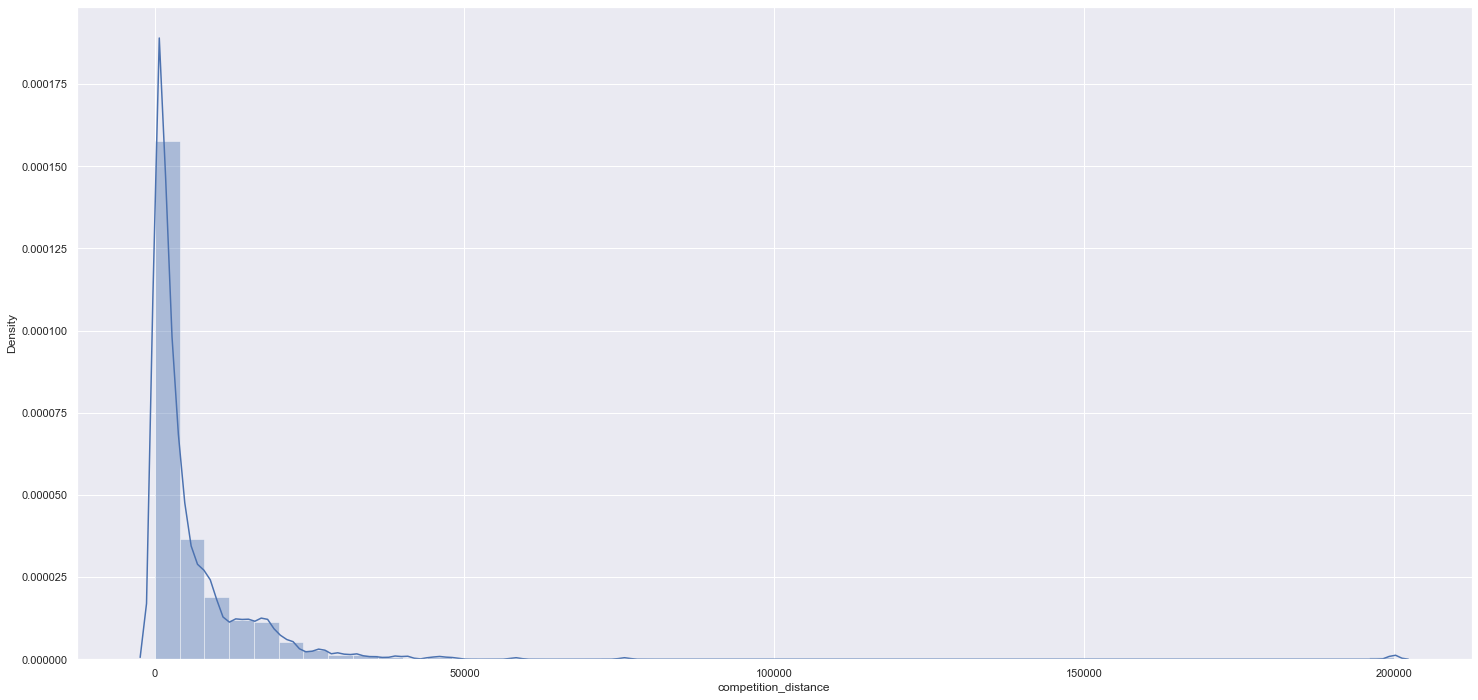

In [18]:
sns.distplot(df1['competition_distance']);

## 1.7.2 Categorical Attributes

In [19]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday                    4
store_type                       4
assortment                       3
competition_open_since_month    12
competition_open_since_year     23
promo2_since_week               52
promo2_since_year                7
promo_interval                   4
month_map                       12
dtype: int64

<Figure size 2160x1440 with 0 Axes>

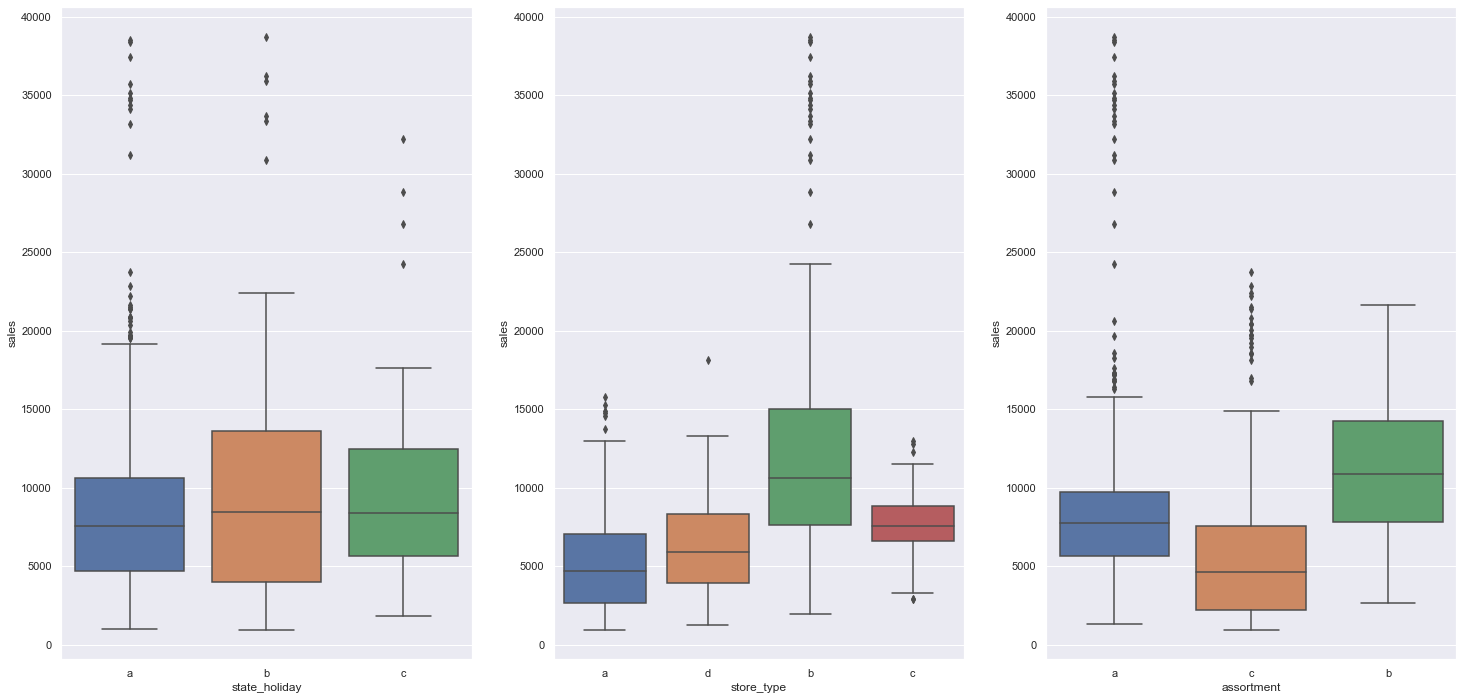

<Figure size 2160x1440 with 0 Axes>

In [20]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)

plt.figure(figsize=(30,20))

# 2.0 PASSO 02 - FEATURE ENGINEERING

In [21]:
df2 = df1.copy()

## 2.1 Mapa mental de hipóteses

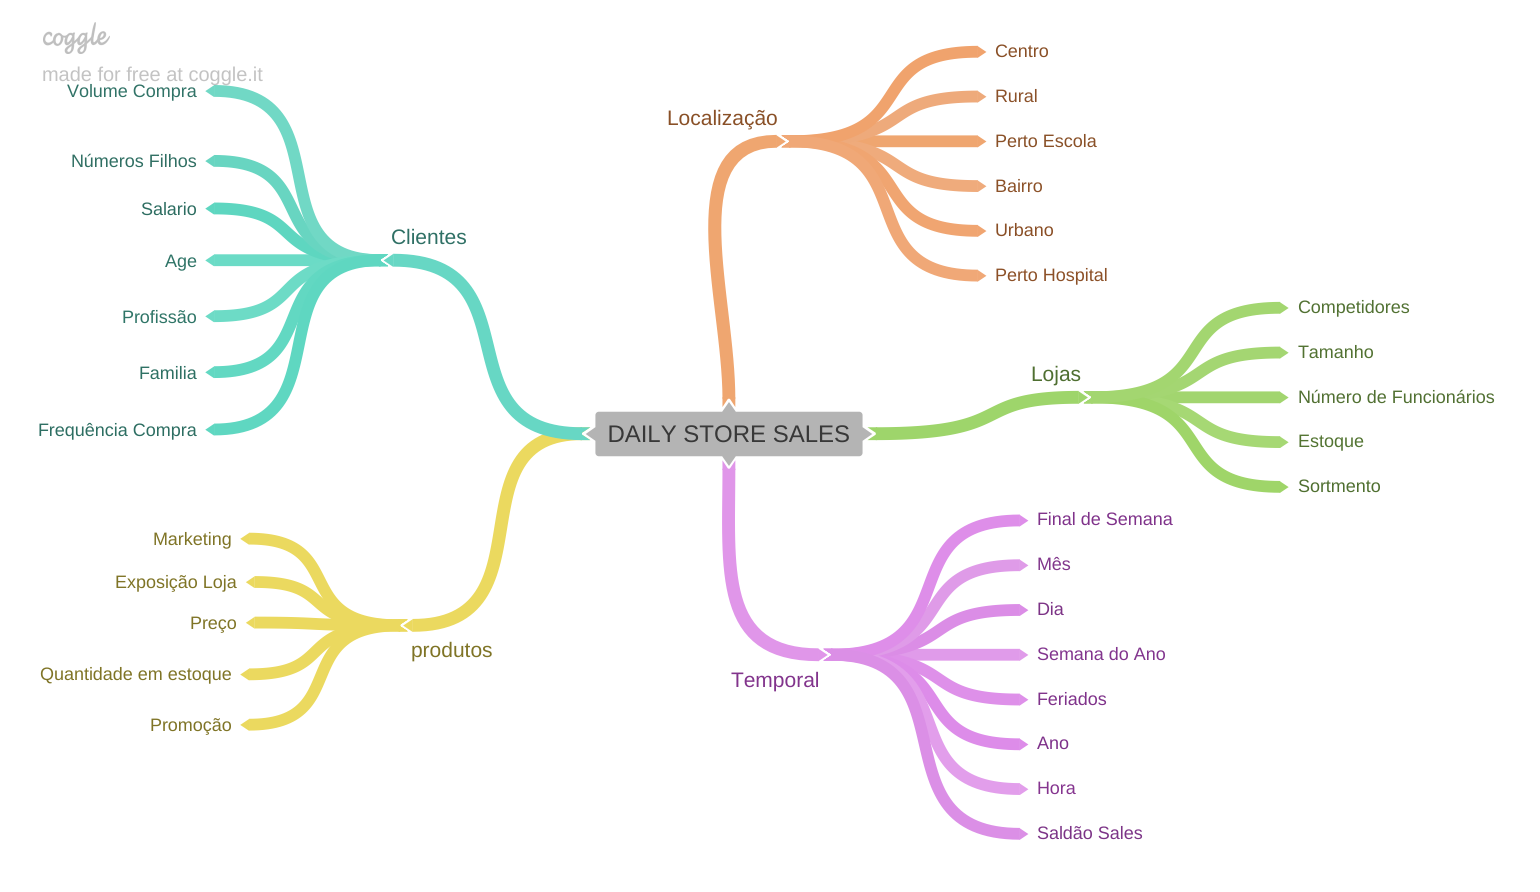

In [22]:
# MAPA MENTAL DE HIPÓTESES
# Fenômeno - Daily Store Sales
# Agentes - Localização, Clientes, Lojas, Temporal, Produtos
# Atributos - Dentro dos agentes
Image(r'C:\\Users\\mlsil\\OneDrive\\Documentos\\repos\\ds_em_producao\\image\\DAILY_STORE_SALES.png')

## 2.2 Criação de hipóteses

### 2.2.1 Hipótese Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2 Hipótese Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 Hipótese Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.


## 2.3 Lista Final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

**8.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**9.** Lojas deveriam vender mais ao longo dos anos.

**10.** Lojas deveriam vender mais no segundo semestre do ano.

**11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**12.** Lojas deveriam vender menos aos finais de semana.

**13.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4 Feature Engineering

In [23]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year Week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = (df2['state_holiday'].apply( lambda
                                                   x: 'public_holiday'if x == 'a' else 'easter_holiday' if
                                                    x == 'b' else 'christmas' if x == 'c'else 'regular_day' ))


In [24]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 PASSO 03 - FILTRAGEM DE VARIÁVEIS



In [25]:
df3 = df2.copy()


## 3.1 Filtragem das linhas


In [26]:
df3 = df3[(df3['open'] !=0 ) & (df3['sales'] > 0)]

## 3.2 Seleção das colunas

In [27]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [28]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 PASSO 04 - ANÁLISE EXPLORATÓRIA DOS DADOS


In [29]:
df4 = df3.copy()

## 4.1. Análise Univariada

### 4.1.1. Response Variable

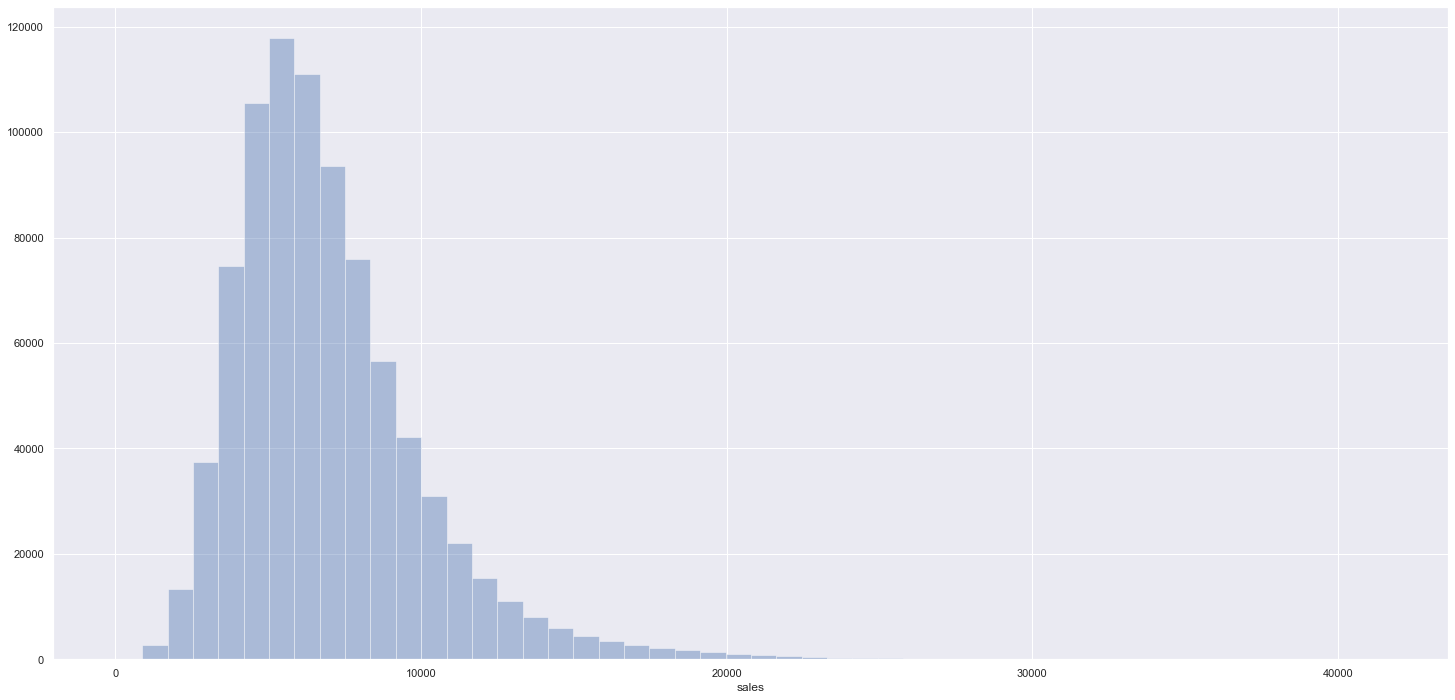

In [30]:
sns.distplot(df4['sales'], kde=False);

### 4.1.2. Numerical Variable

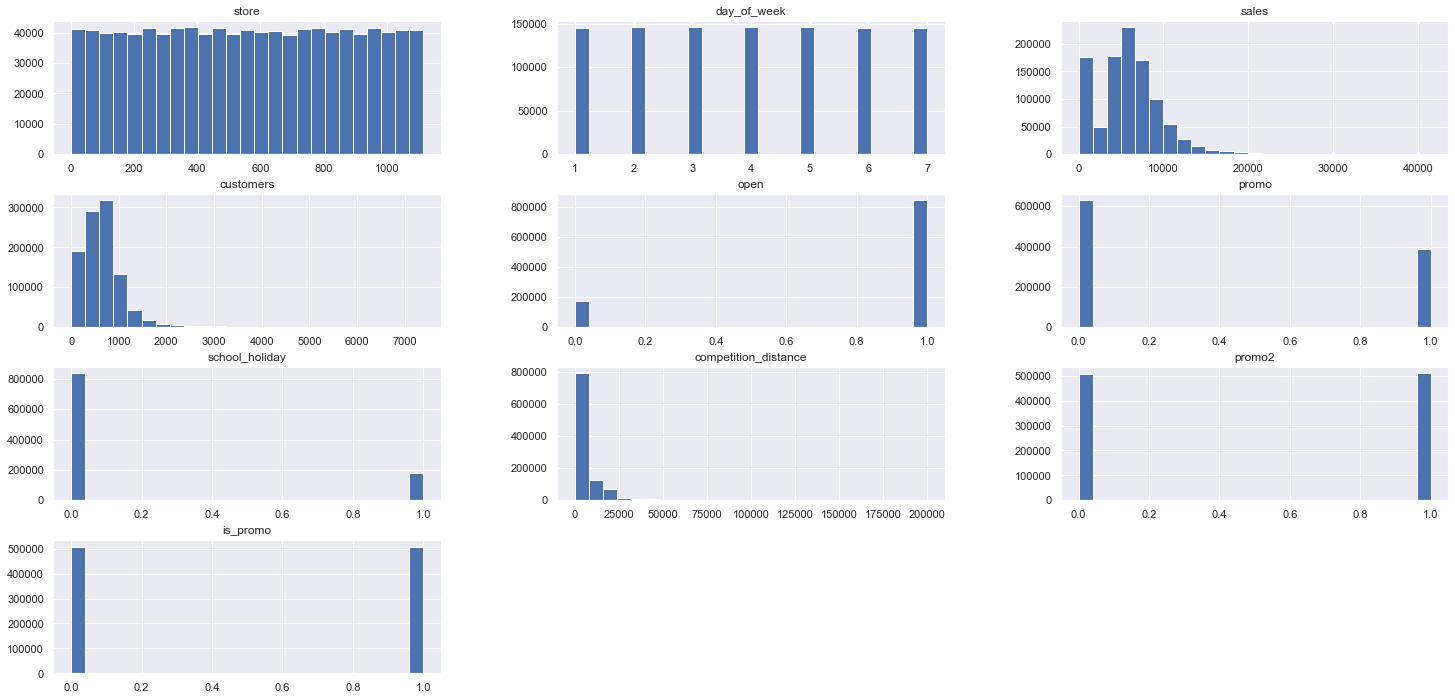

In [31]:
num_attributes.hist(bins=25);

### 4.1.3. Categorical Variable

In [32]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

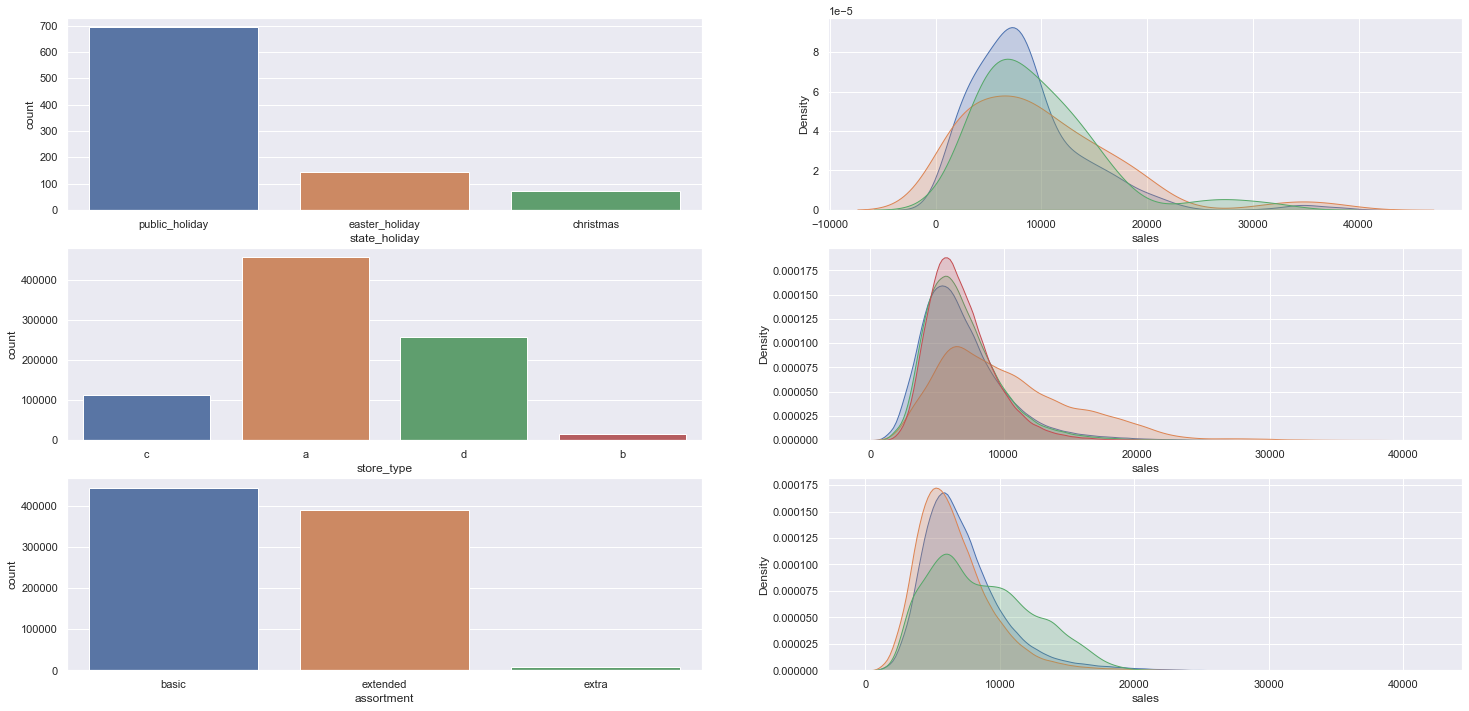

In [33]:
# state_holiday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( x=a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

# store_type
plt.subplot(3, 2, 3)
sns.countplot( x=df4['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

# assortment
plt.subplot(3, 2, 5)
sns.countplot( x=df4['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True);

## 4.2. Análise bivariada

### H1. Lojas com maior sortimentos, deveriam vender mais.

*Falsa!* Lojas com MAIOR SORTIMENTO  vendem MENOS

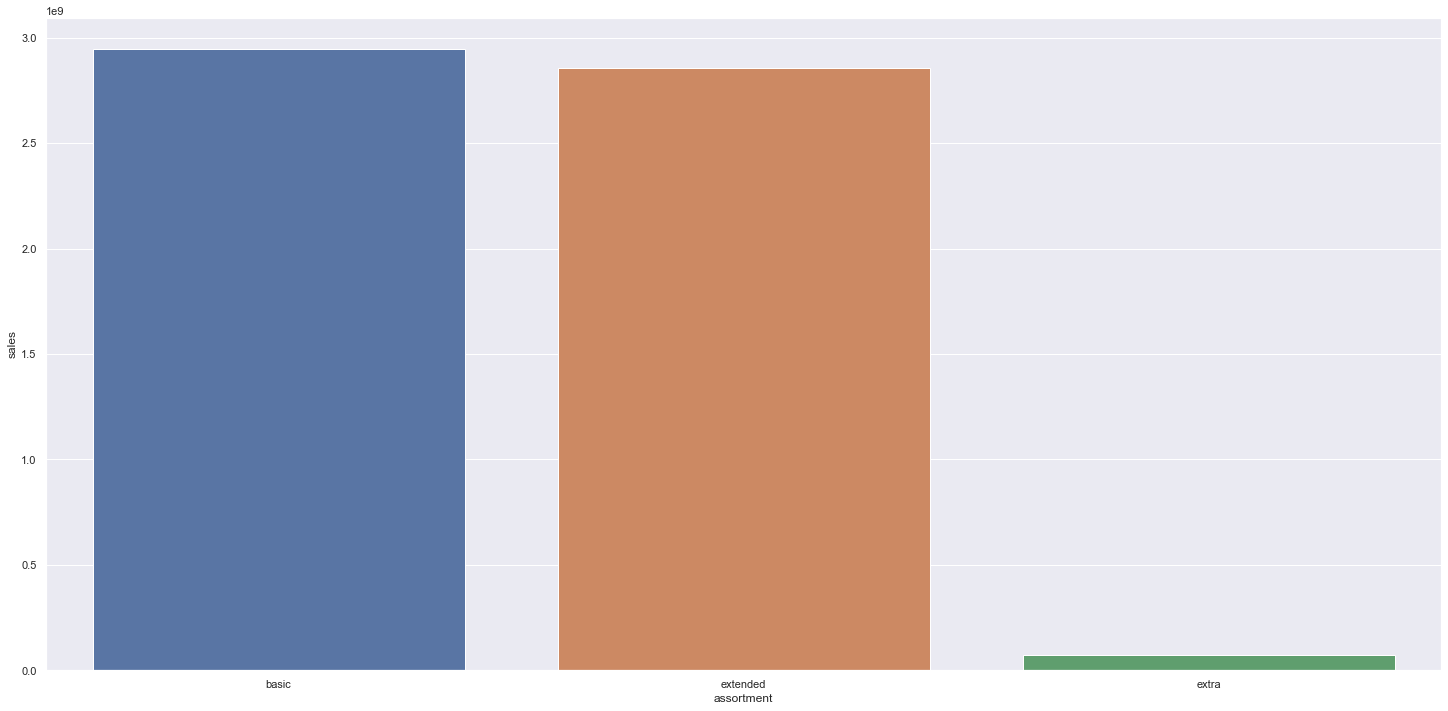

In [34]:
# Gráfico 01
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

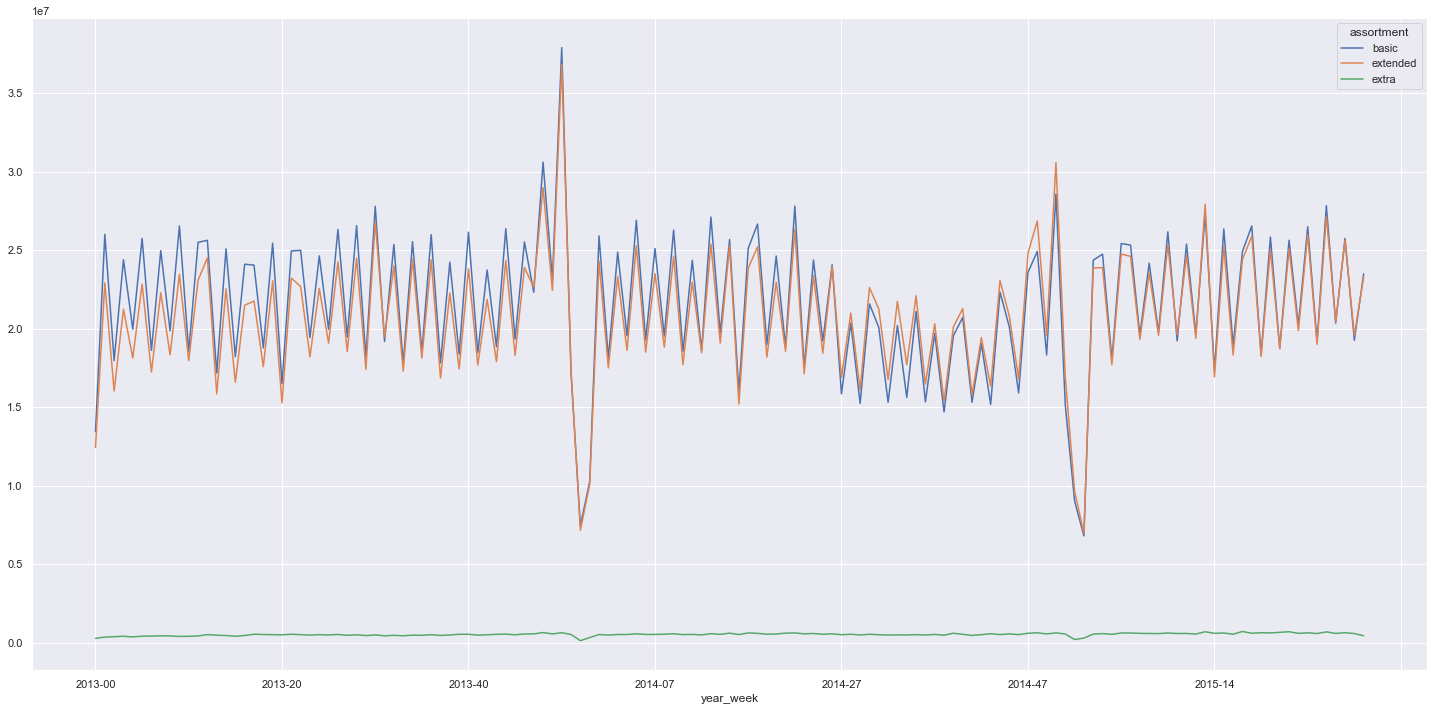

In [35]:
# Gráfico 02
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot();

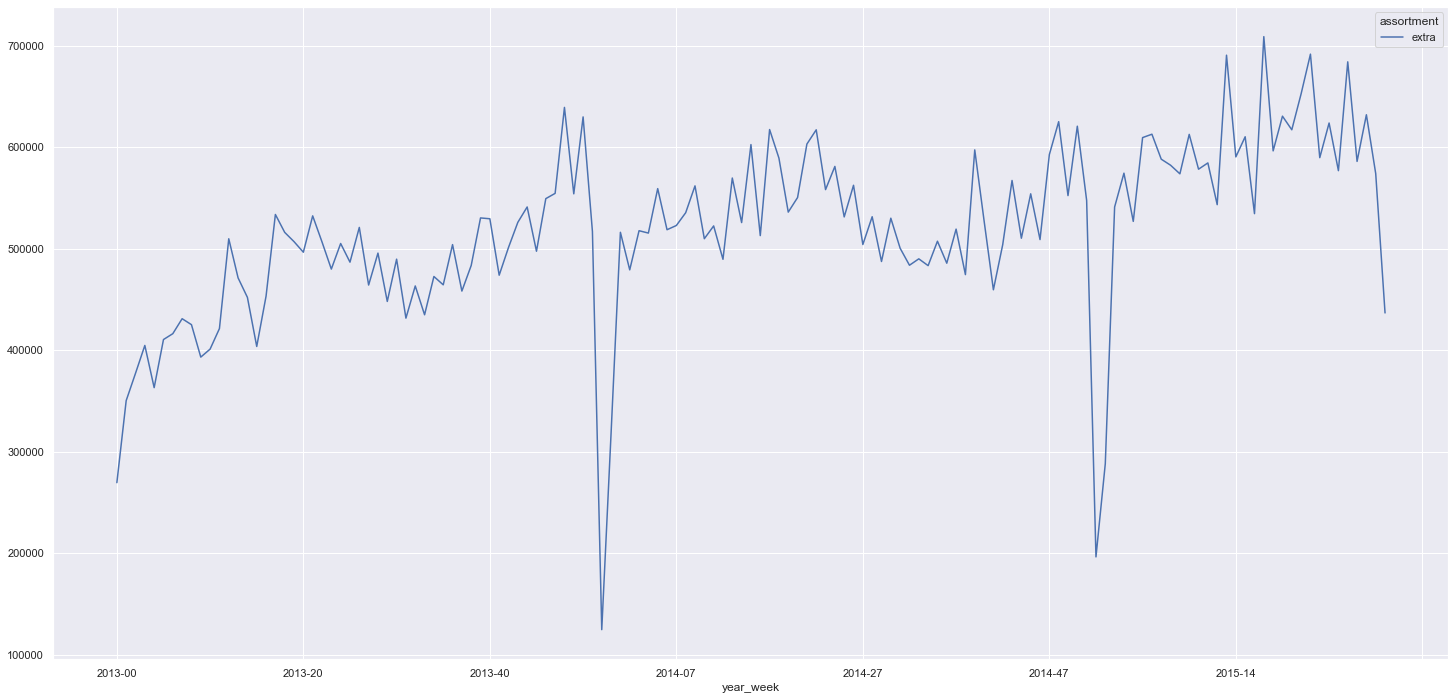

In [36]:
# Gráfico 03
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot();

### H2. Lojas com competidores mais próximos, deveriam vender menos.

*Falsa!* Lojas com COMPETIDORES MAIS PRÓXIMOS, vendem MAIS.

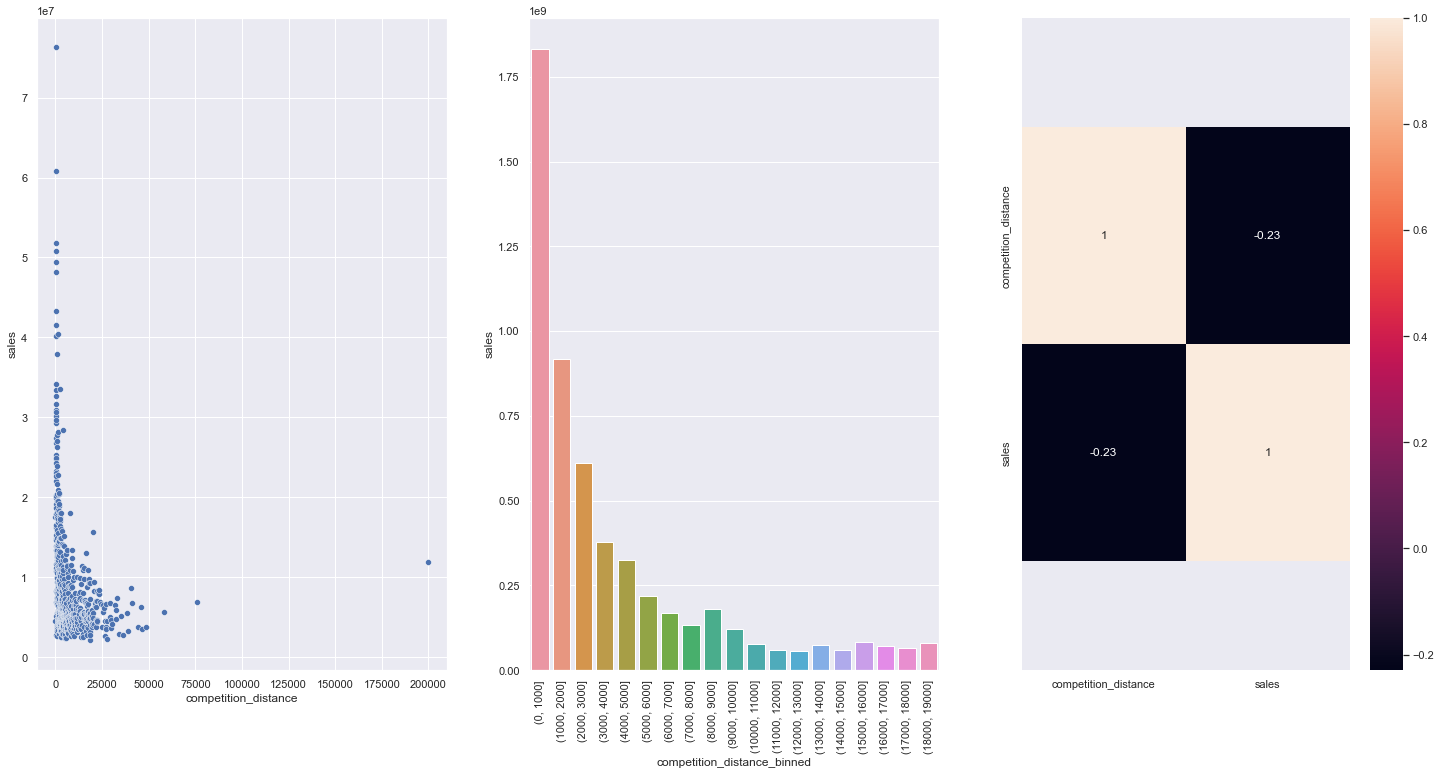

In [37]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

# Gráfico 01
plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

# Gráfico 02
plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90);

# Gráfico 03
plt.subplot(1, 3, 3)
x = sns.heatmap(aux1.corr(method='pearson'), annot=True);
bottom, top = x.get_ylim()
x.set_ylim(bottom+0.5, top-0.5);

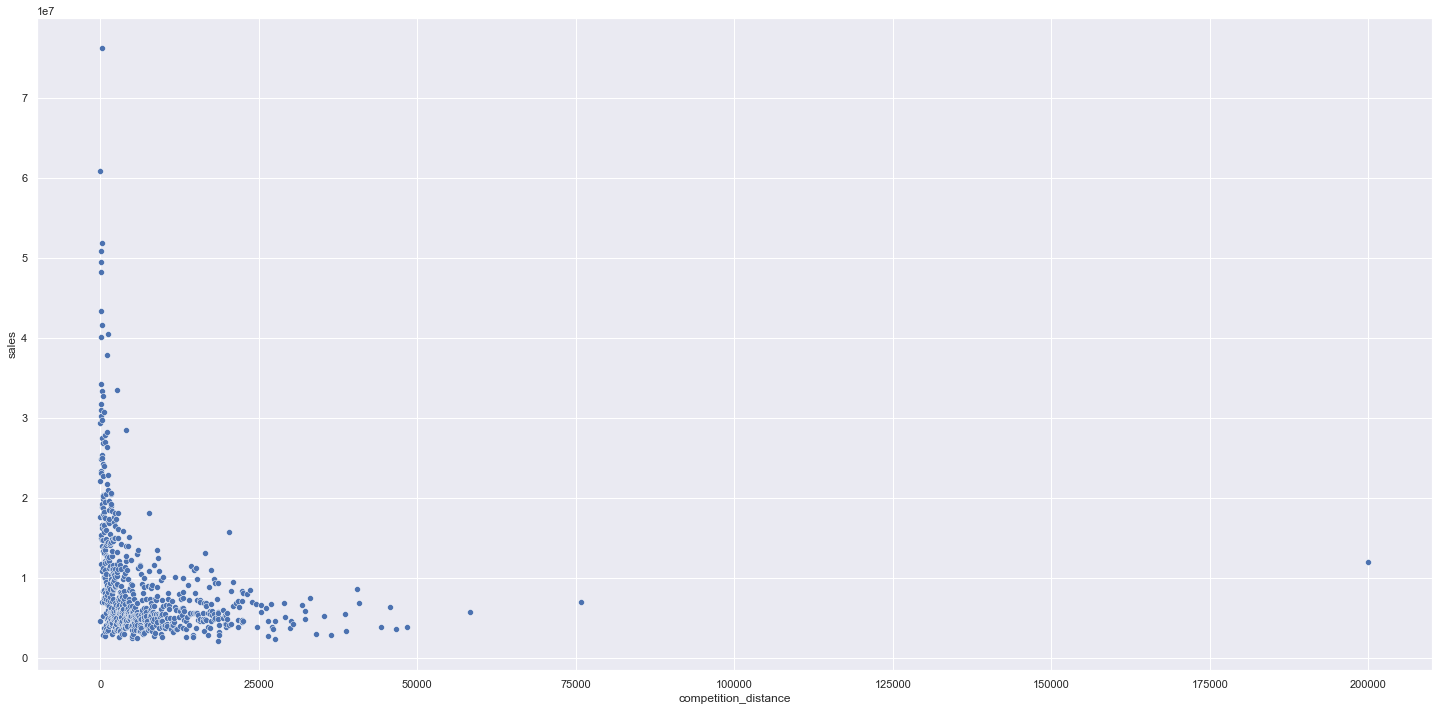

In [38]:
# Gráfico 01
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

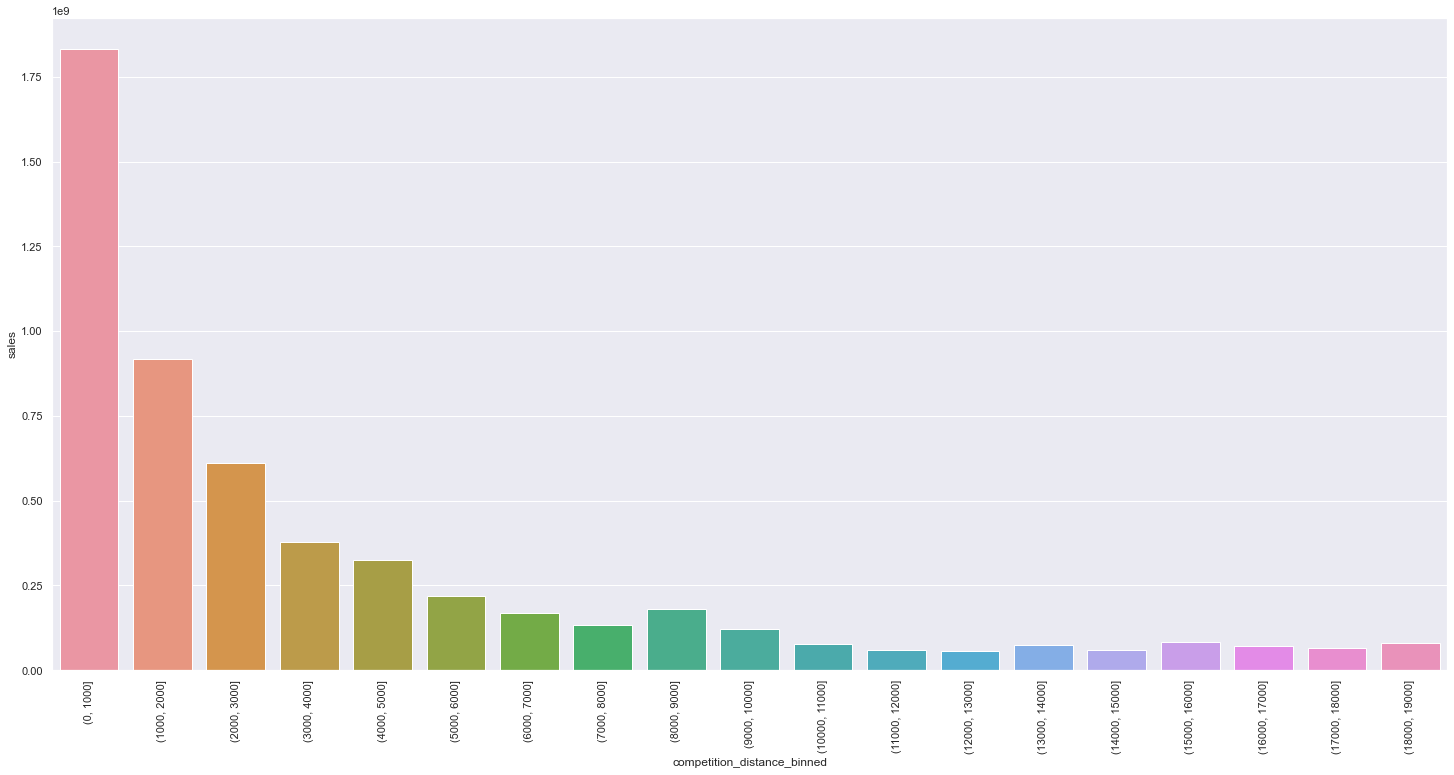

In [39]:
# Gráfico 02
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90);


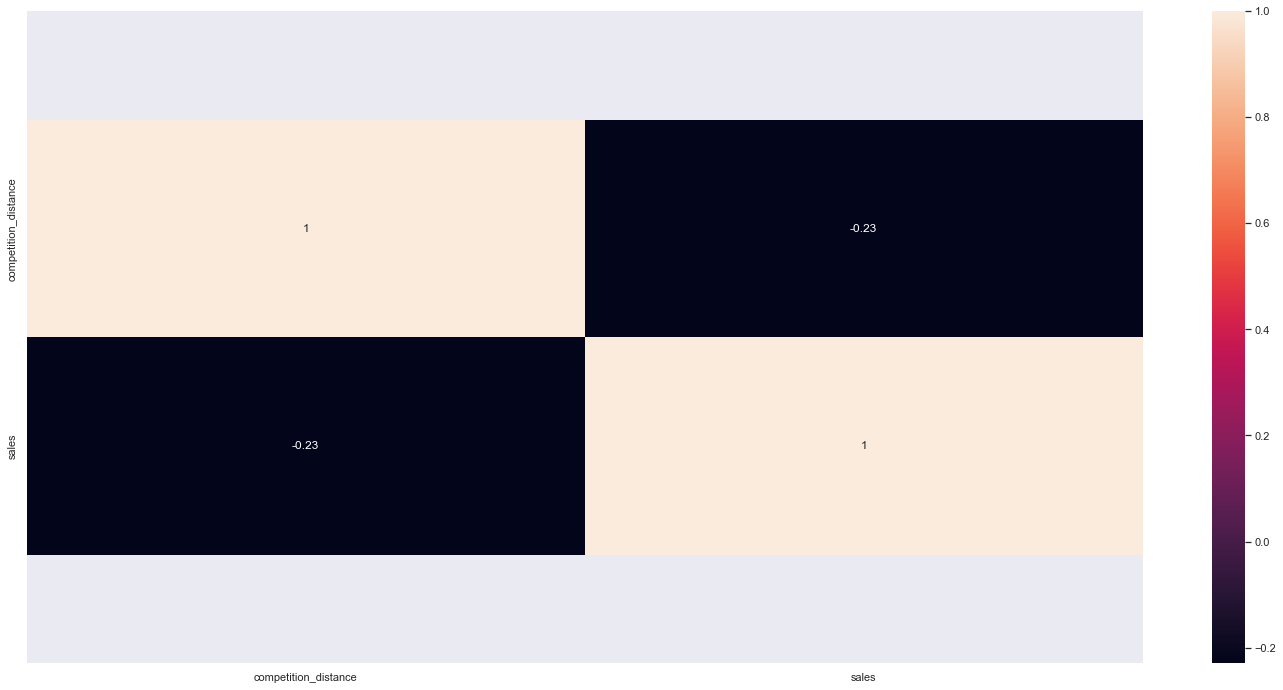

In [40]:
# Gráfico 03
x = sns.heatmap(aux1.corr(method='pearson'), annot=True);
bottom, top = x.get_ylim()
x.set_ylim(bottom+0.5, top-0.5);

### H3. Lojas com competidores à mais tempo, deveriam vender mais.
*Falsa!* Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS.

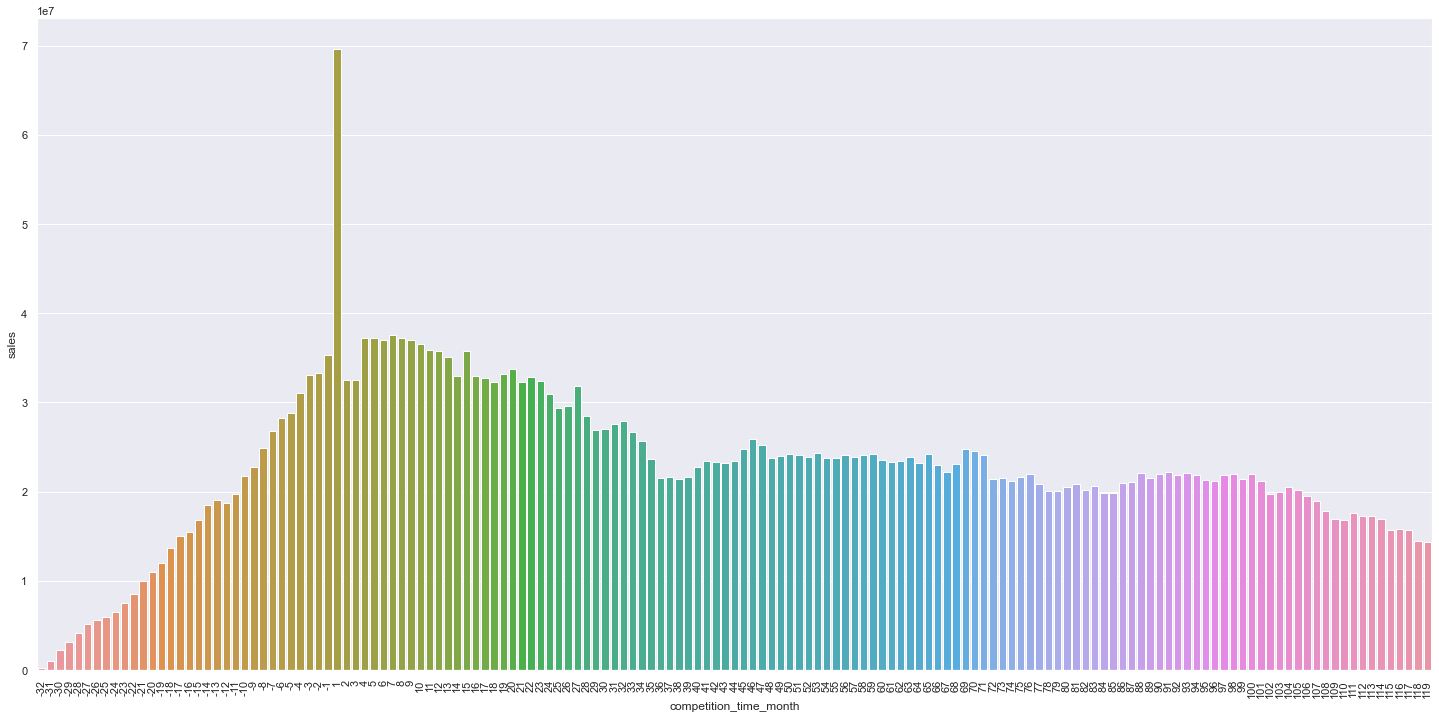

In [41]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

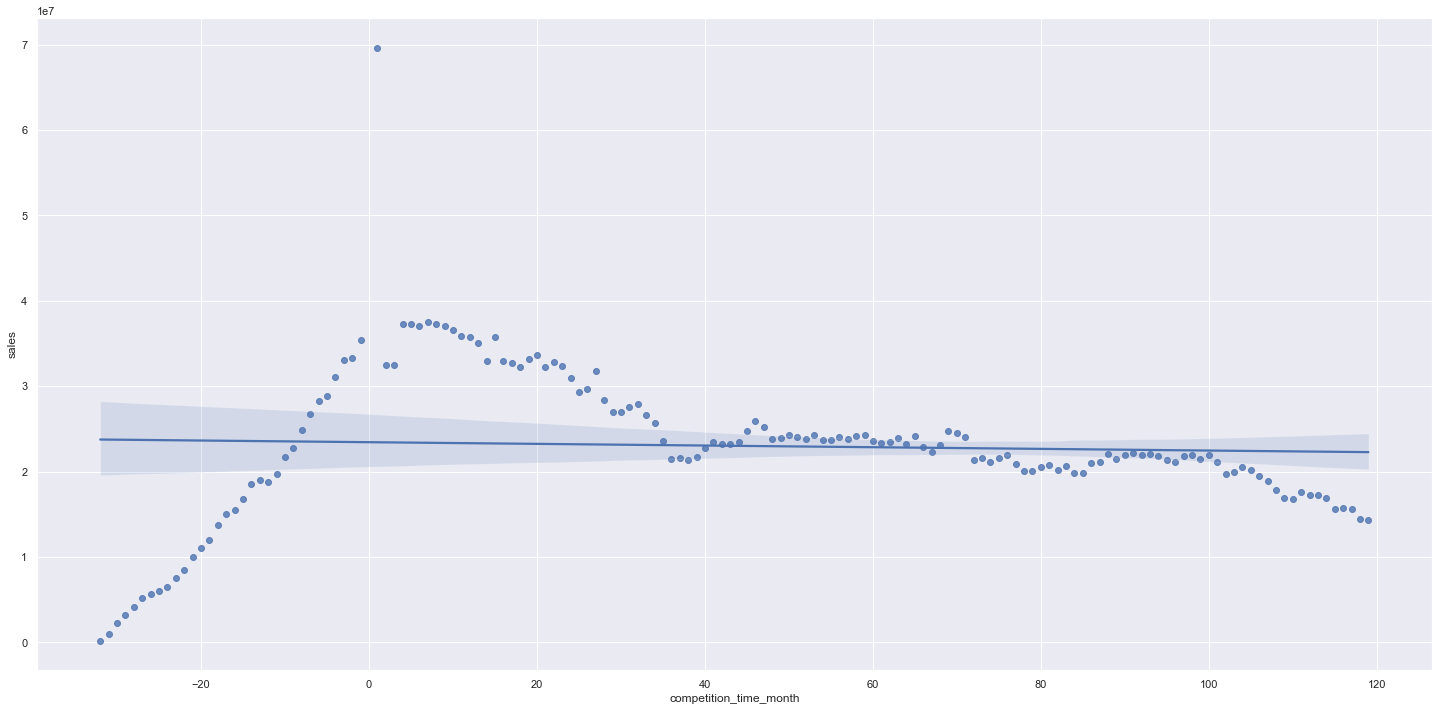

In [42]:
sns.regplot(x='competition_time_month', y='sales', data=aux2);

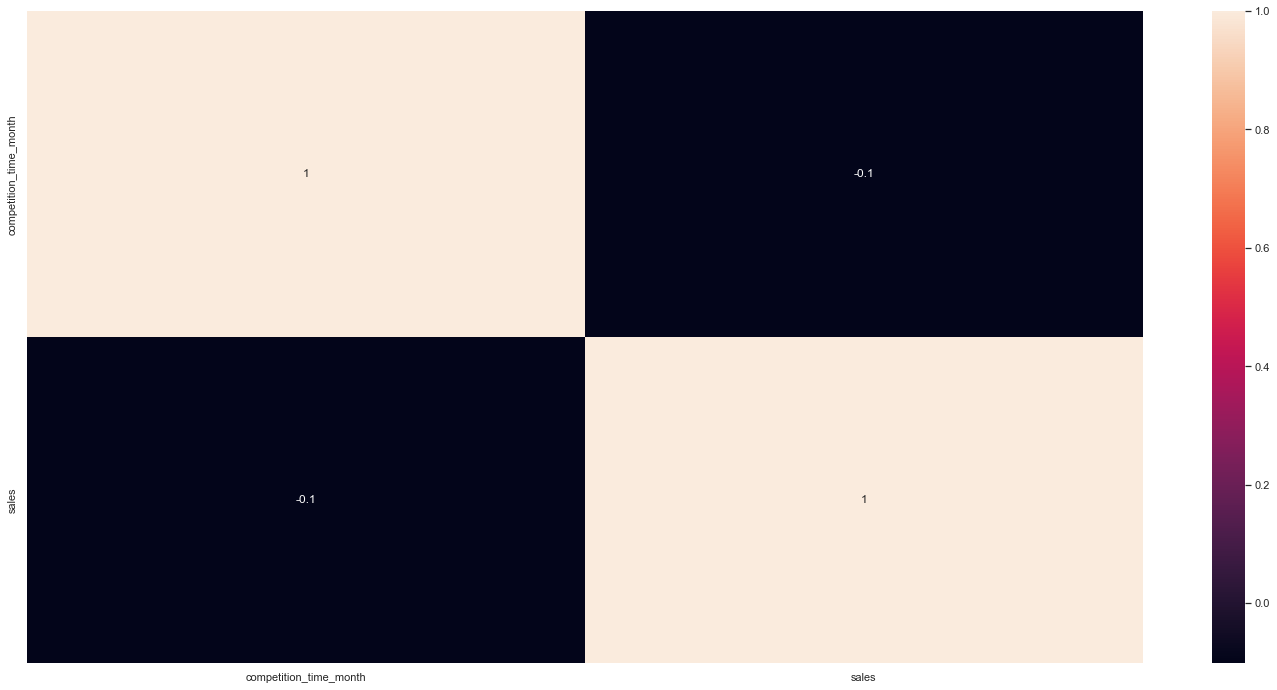

In [43]:
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H4. Lojas com promoções ativas por mais tempo, deveriam vender mais.
*Falsa!* Lojas com promoções ativas por mais tempo vendem menos, depois de um certo tempo de promoção.

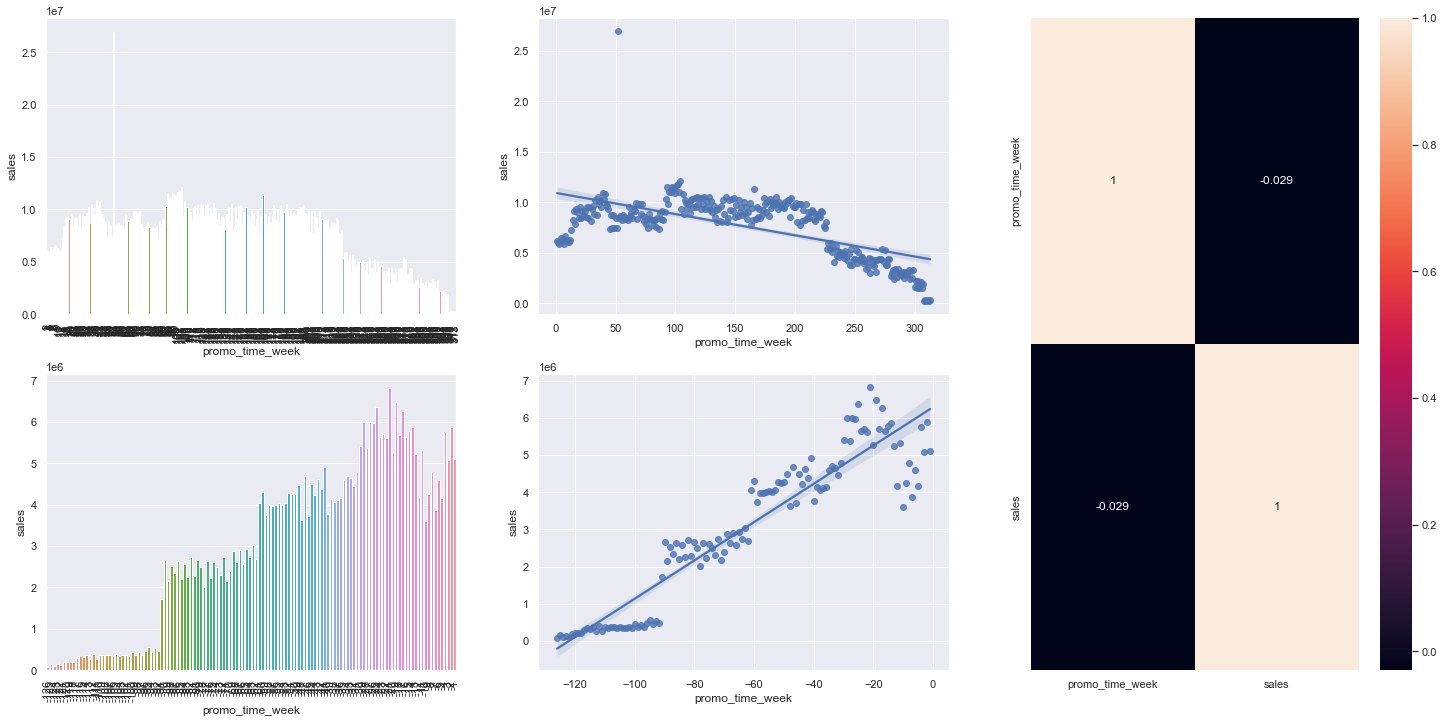

In [44]:
from matplotlib.figure import GridSpec
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2, 3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### <s>H5. Lojas com mais dias de promoção, deveriam vender mais.</s>

### H6. Lojas com mais promoções consecutivas, deveriam ,vender mais.
*Falsa!* Lojas com mais promoções consecutivas, vendem menos.

In [45]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


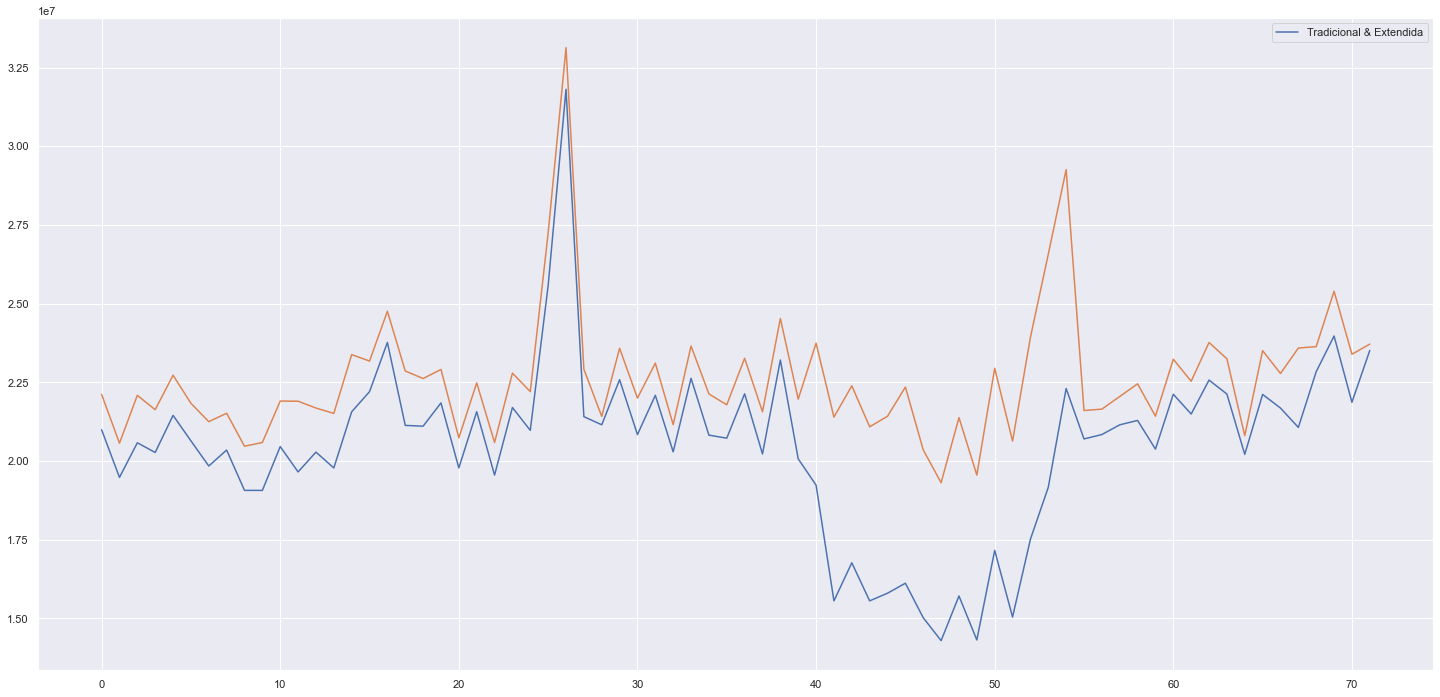

In [46]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional & Extendida']);

### H8. Lojas abertas durante o feriado de Natal, deveriam vender mais.
**Falsa!** Lojas abertas durante o feriado, vendem MENOS.

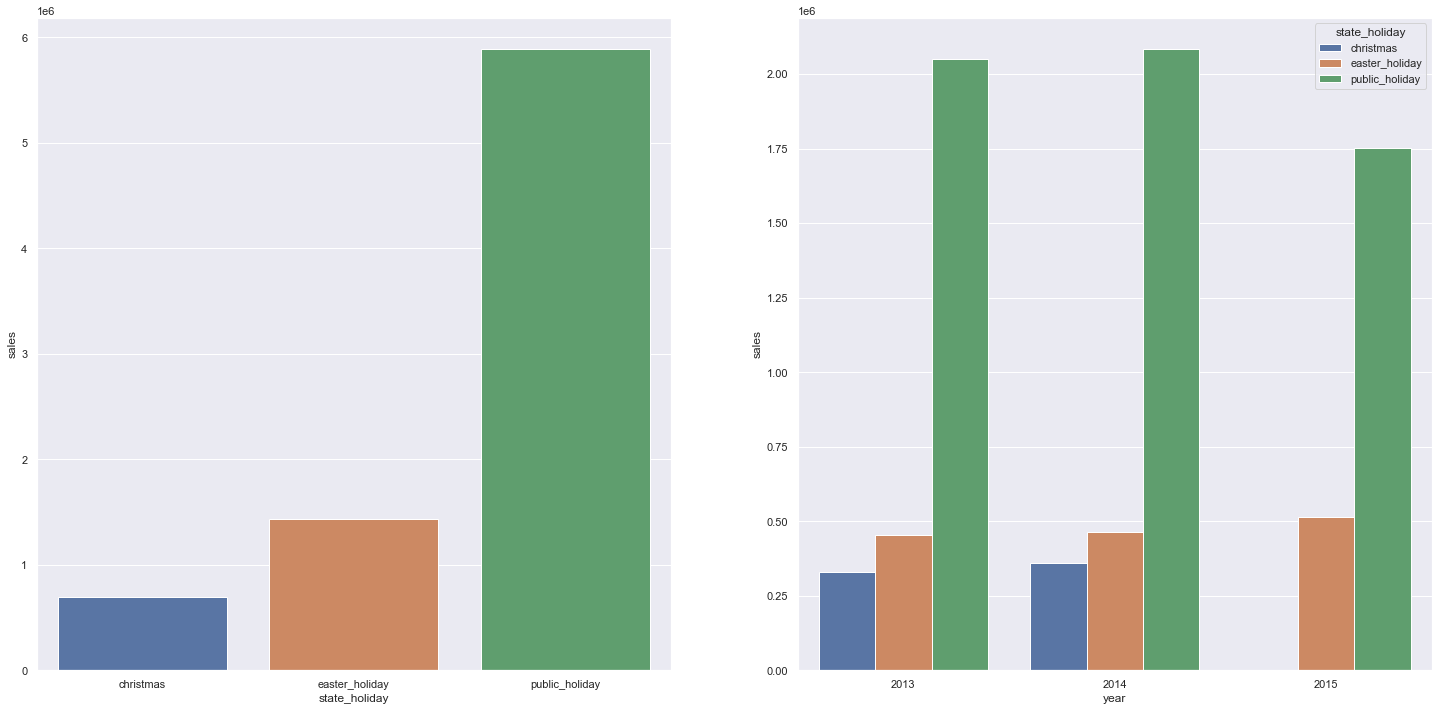

In [47]:
aux = df4[df4['state_holiday'] != 'regular_day']

# Gráfico 01
plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

# Gráfico 02
plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales',hue='state_holiday', data=aux2);

### H9. Lojas deveriam vender mais ao longo dos anos.
**Falsa!** Lojas vendem MENOS ao longo dos anos.

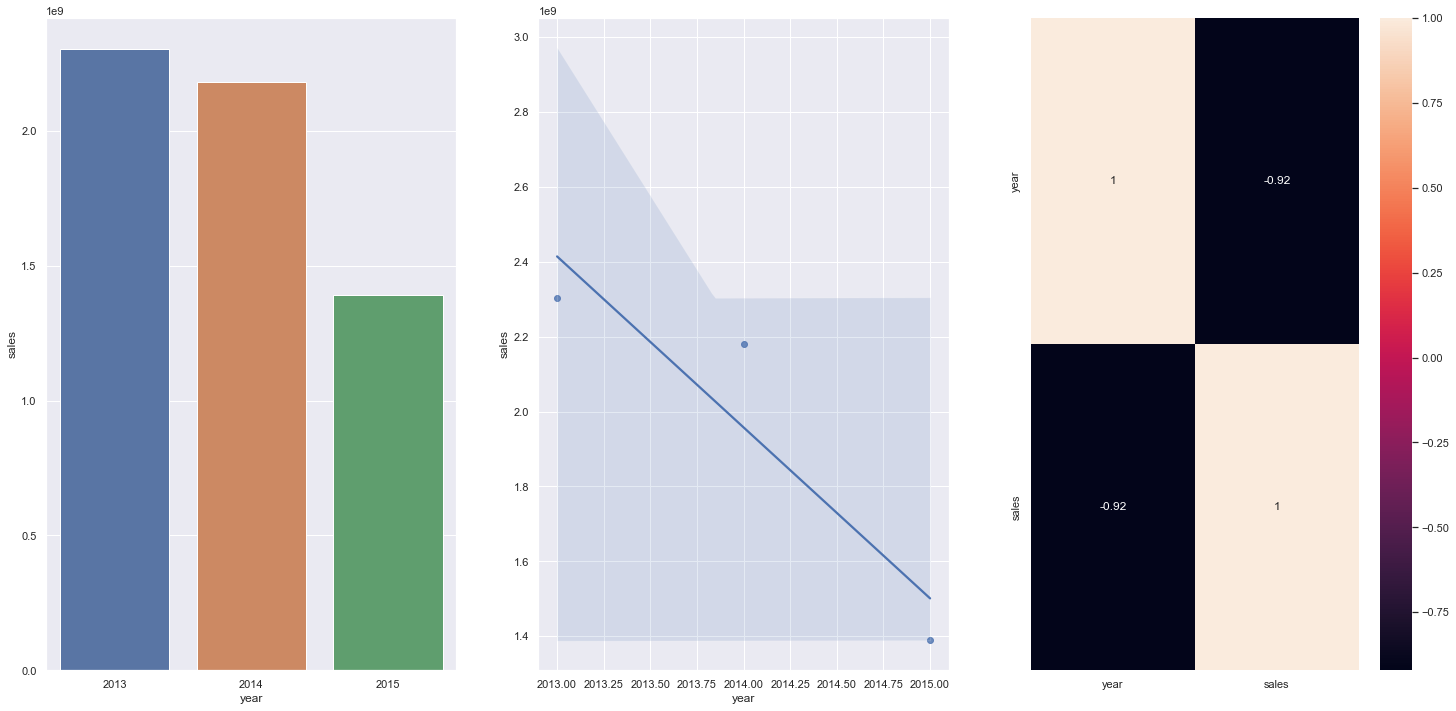

In [48]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

# Gráfico 01
plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1);

# Gráfico 02
plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1);

# Gráfico 03
plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H10.Lojas deveriam vender mais no segundo semestre do ano.
**Falsa!** Lojas vendem menos no segundo semestre do ano.

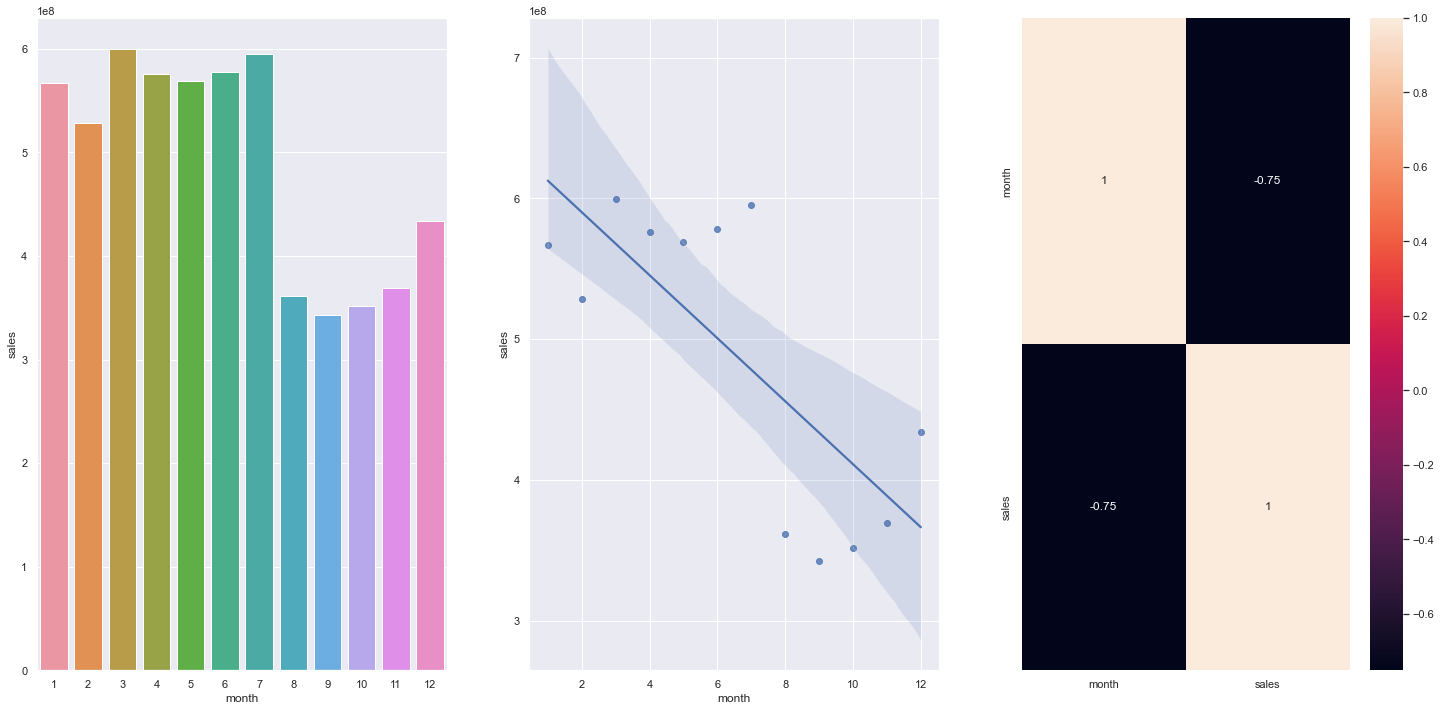

In [49]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

# Gráfico 01
plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1);

# Gráfico 02
plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1);

# Gráfico 03
plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H11. Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA!**Lojas vendem mais depois do dia 10 de cada mês.

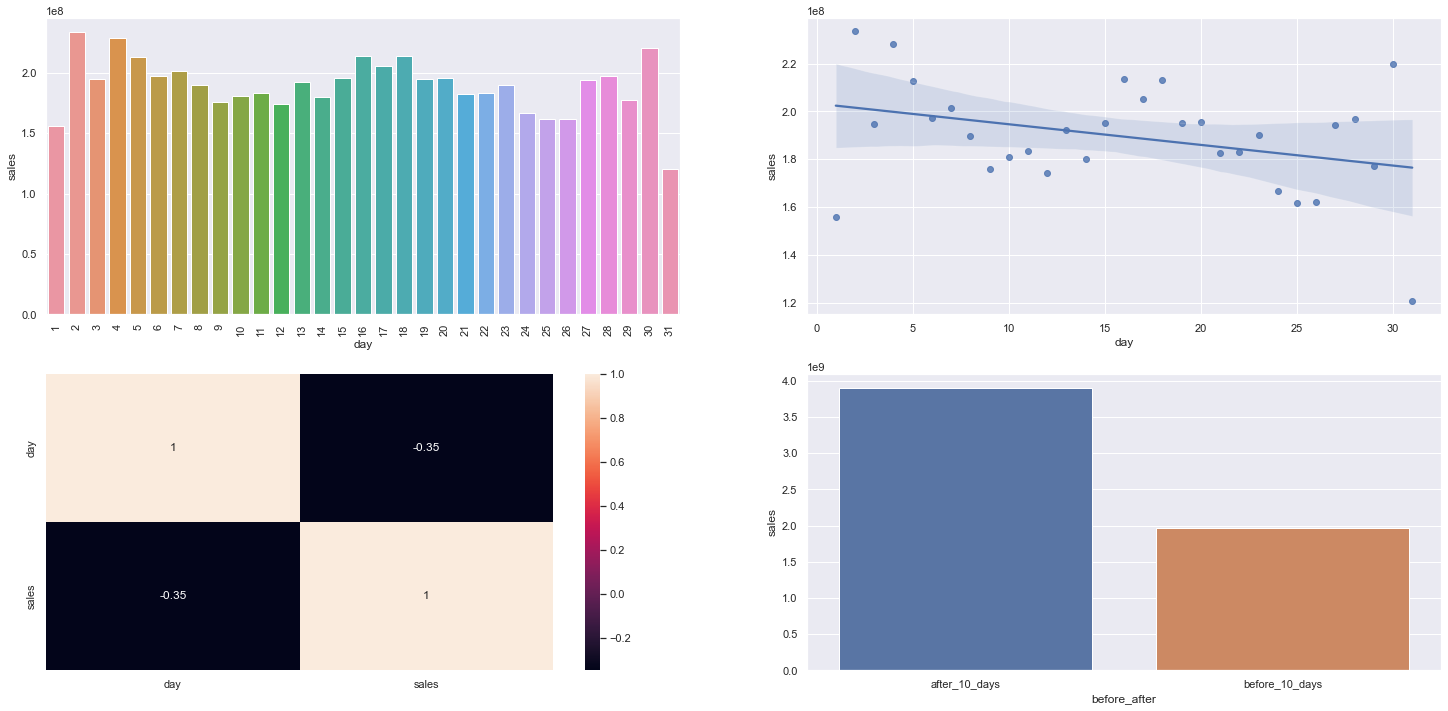

In [50]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

# Gráfico 01
plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1);
plt.xticks(rotation=90);

# Gráfico 02
plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1);

# Gráfico 03
plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <=10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

# gráfico 04
plt.subplot(2, 2, 4)
sns.barplot(x='before_after', y='sales', data=aux2);

### H12. Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA!** Lojas vendem menos nos finais de semana.

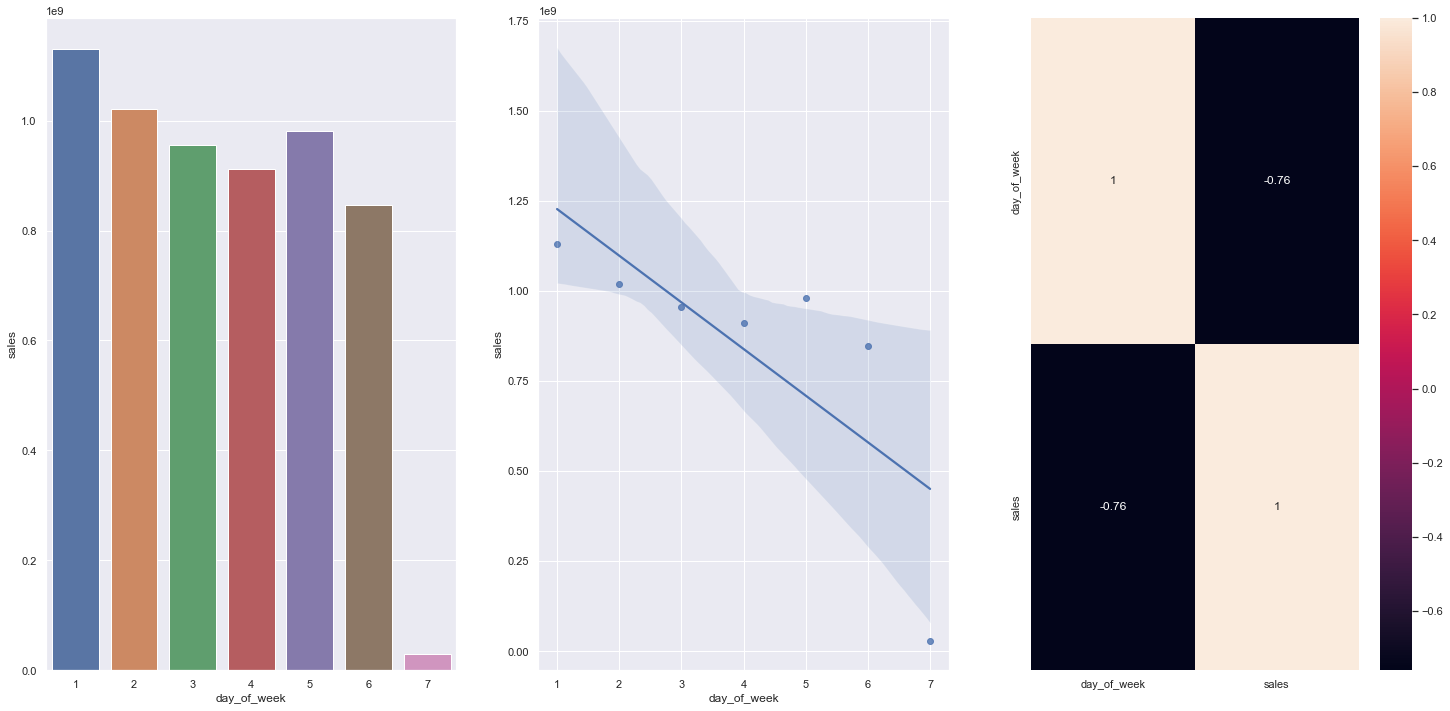

In [51]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

# Gráfico 01
plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

# Gráfico 02
plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

# Gráfico 03
plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H13. Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA!** Lojas vendem menos durante os feriados escolares, exceto os meses de Julho e Agosto.

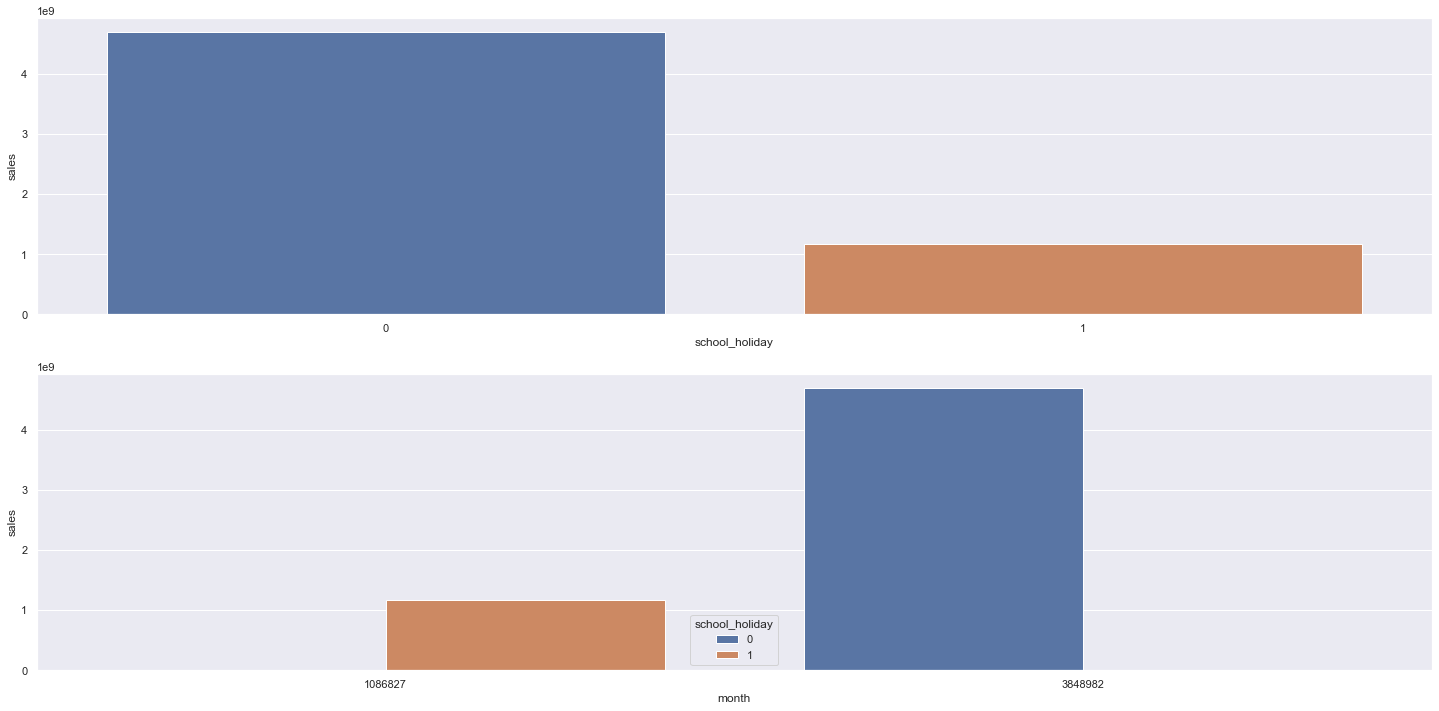

In [52]:
# Gráfico 01
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2, 1, 1)
sns.barplot(x='school_holiday', y='sales', data=aux1);

# Gráfico 02
aux2 = df4[['month', 'school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2, 1, 2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

### 4.2.1. Resumo das hipoteses

In [53]:
from tabulate import tabulate

In [54]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1', 'Falsa', 'Baixa'],
      ['H2', 'Falsa', 'Media'],
      ['H3', 'Falsa', 'Media'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', '-', '-'],
      ['H7', 'Falsa', 'Baixa'],
      ['H8', 'Falsa', 'Media'],
      ['H9', 'Falsa', 'Alta'],
      ['H10', 'Falsa', 'Alta'],
      ['H11', 'Verdadeira', 'Alta'],
      ['H12', 'Verdadeira', 'Alta'],
      ['H13', 'Verdadeira', 'Baixa'],
      ]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


## 4.3. Anásilse Multivariada

### 4.3.1 Numerical Attributes

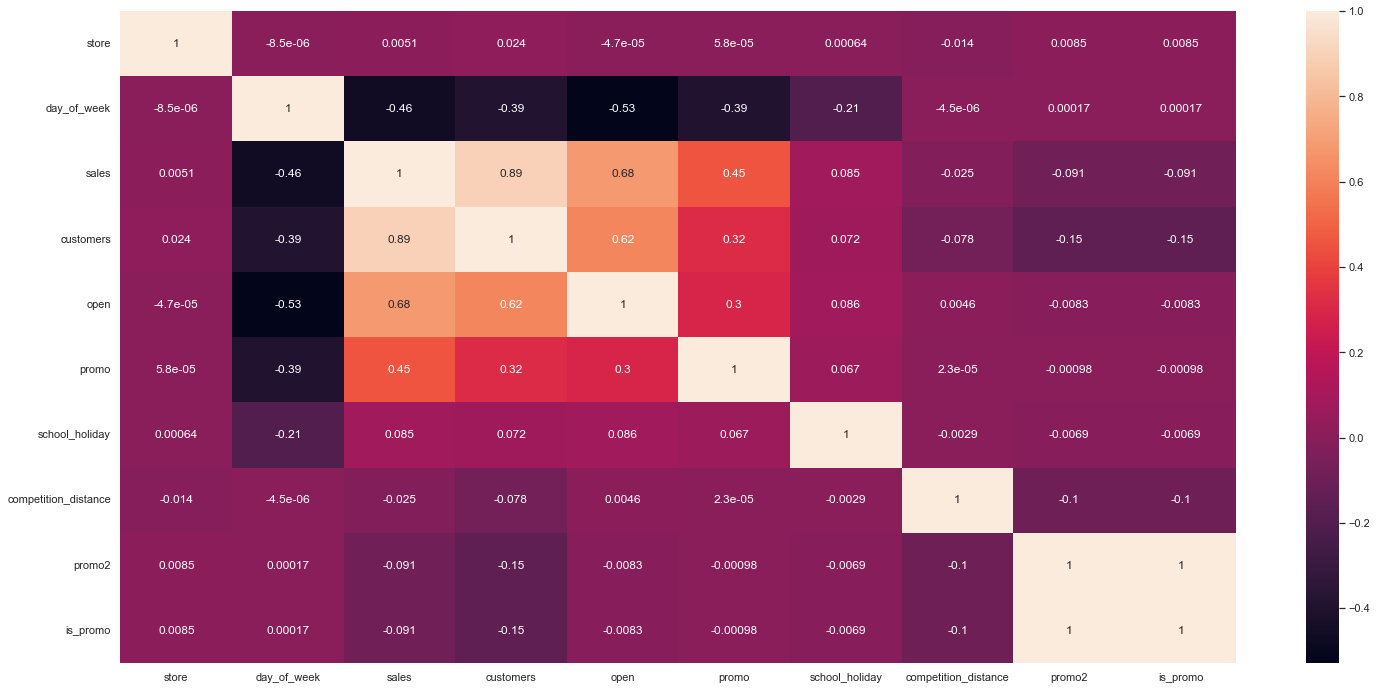

In [55]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2 Categorical Attributes

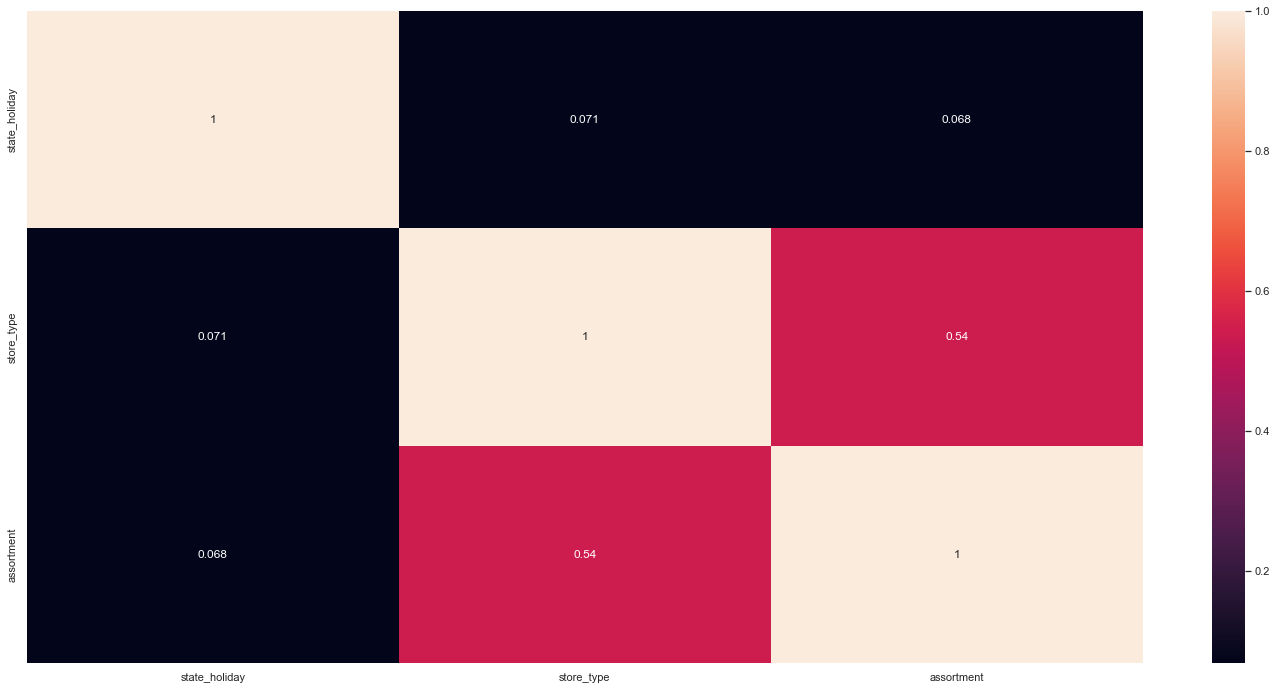

In [56]:
# only categorical data
a = df4.select_dtypes(include='object')

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
                   'store_type': [a4, a5, a6],
                   'assortment': [a7, a8, a9] } )
d = d.set_index(d.columns)

# heatmap
sns.heatmap(d, annot=True);

# 5.0. PASSO 05 - DATA PREPARATION

In [57]:
df5 = df4.copy()

## 5.1. Normalização

## 5.2. Rescaling

In [58]:
'''
Min-Max-Scaler

Xnew = Xi - μ / (Xmax - Xmin)
μ = média

Robust Scaler

Xnew = (Xi) - (Q1(X)) / (Q3(x) - (Q1(x)))

'''

'\nMin-Max-Scaler\n\nXnew = Xi - μ / (Xmax - Xmin)\nμ = média\n\nRobust Scaler\n\nXnew = (Xi) - (Q1(X)) / (Q3(x) - (Q1(x)))\n\n'

In [59]:
# selecionando todos os dados numéricos
a = df5.select_dtypes(include=['int64', 'float64'])

In [60]:
# sns.boxplot(df5['competition_distance']);
# sns.boxplot(df5['competition_time_month']);
# sns.boxplot(df5['promo_time_week']);
# sns.boxplot(df5['year']);

In [61]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open(r'C:\\Users\\mlsil\\OneDrive\\Documentos\\repos\\ds_em_producao\\parameter\\competition_distance_scaler.pkl', 'wb'))

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open(r'C:\\Users\\mlsil\\OneDrive\\Documentos\\repos\\ds_em_producao\\parameter\\competition_time_month.pkl', 'wb'))

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(rs, open(r'C:\\Users\\mlsil\\OneDrive\\Documentos\\repos\\ds_em_producao\\parameter\\promo_time_week.pkl', 'wb'))

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open(r'C:\\Users\\mlsil\\OneDrive\\Documentos\\repos\\ds_em_producao\\parameter\\year_scaler.pkl', 'wb'))

## 5.3. Transformação

### 5.3.1. Encoding

In [62]:
'''
ENCODING = Selecionar a variável categória, transformar em variável numérica, mantendo o conteúdo de informação
'''
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open(r'C:\\Users\\mlsil\\OneDrive\\Documentos\\repos\\ds_em_producao\\parameter\\store_type_scaler.pkl', 'wb'))

# assortment - Ordinal Encoding
assortment_dict = {'basic':1, 'extra':2, 'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2. Response Variable Transformation

In [63]:
df5['sales'] = np.log1p(df5['sales'])

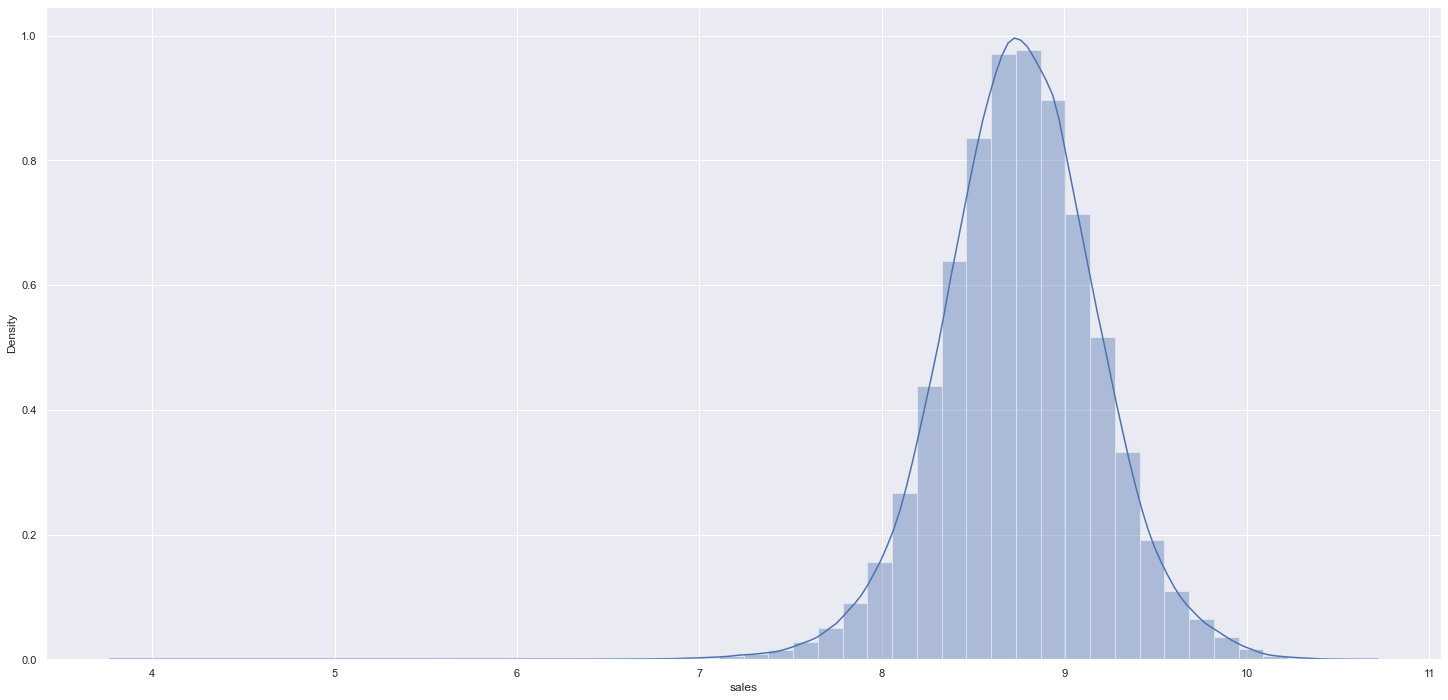

In [64]:
sns.distplot(df5['sales']);

### 5.3.3. Nature transformation

In [65]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

In [66]:
df5.sample(10)

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
359330,557,5,2014-08-22,8.309185,1,0,0,1,-0.335484,8,2014,0,34,2014,0,0.5,8,22,34,2014-33,2014-08-01,-0.216216,2014-08-18,0.287016,0,0,0,1,-0.974928,-0.222521,-8.660254e-01,-5.000000e-01,-9.945219e-01,-0.104528,-0.822984,-0.568065
890965,866,3,2013-04-24,8.717027,1,0,3,1,1.185484,4,2013,1,5,2013,1,0.0,4,24,17,2013-16,2013-04-01,-0.216216,2013-01-28,0.314351,0,0,0,1,0.433884,-0.900969,8.660254e-01,-5.000000e-01,-9.510565e-01,0.309017,0.885456,-0.464723
279795,481,6,2014-11-15,8.528529,0,0,2,3,0.829032,11,2014,1,44,2012,1,0.5,11,15,46,2014-45,2014-11-01,-0.216216,2012-10-22,0.530752,0,0,0,1,-0.781831,0.623490,-5.000000e-01,8.660254e-01,1.224647e-16,-1.000000,-0.663123,0.748511
844867,483,2,2013-06-04,8.603004,1,0,0,3,-0.003226,9,2011,1,13,2010,1,0.0,6,4,23,2013-22,2011-09-01,0.067568,2010-03-22,0.667426,0,0,0,1,0.974928,-0.222521,1.224647e-16,-1.000000e+00,7.431448e-01,0.669131,0.354605,-0.935016
95754,980,4,2015-05-07,8.980424,1,0,0,1,0.337097,9,2005,0,19,2015,0,1.0,5,7,19,2015-18,2005-09-01,1.364865,2015-05-04,0.287016,0,0,0,1,-0.433884,-0.900969,5.000000e-01,-8.660254e-01,9.945219e-01,0.104528,0.748511,-0.663123
340945,937,4,2014-09-11,8.514189,0,0,3,1,0.077419,9,2014,1,10,2014,1,0.5,9,11,37,2014-36,2014-09-01,-0.216216,2014-03-03,0.348519,0,0,0,1,-0.433884,-0.900969,-1.000000e+00,-1.836970e-16,7.431448e-01,-0.669131,-0.970942,-0.239316
879218,269,6,2013-05-04,8.892749,0,0,0,3,-0.366129,6,2015,0,18,2013,0,0.0,5,4,18,2013-17,2015-06-01,-0.567568,2013-04-29,0.287016,0,0,0,1,-0.781831,0.623490,5.000000e-01,-8.660254e-01,7.431448e-01,0.669131,0.822984,-0.568065
541207,103,1,2014-03-03,8.849227,1,0,3,3,0.464516,5,2015,0,10,2014,0,0.5,3,3,10,2014-09,2015-05-01,-0.418919,2014-03-03,0.287016,0,0,0,1,0.781831,0.623490,1.000000e+00,6.123234e-17,5.877853e-01,0.809017,0.935016,0.354605
479092,428,1,2014-04-28,9.104202,1,0,3,1,0.101613,12,2014,1,23,2015,1,0.5,4,28,18,2014-17,2014-12-01,-0.324324,2015-06-01,0.157175,0,0,0,1,0.781831,0.623490,8.660254e-01,-5.000000e-01,-4.067366e-01,0.913545,0.822984,-0.568065
118815,626,4,2015-04-16,9.213236,1,0,2,3,1.356452,11,2013,0,16,2015,0,1.0,4,16,16,2015-15,2013-11-01,0.013514,2015-04-13,0.287016,0,0,0,1,-0.433884,-0.900969,8.660254e-01,-5.000000e-01,-2.079117e-01,-0.978148,0.935016,-0.354605


# 6.0. PASSO 06 - FEATURE SELECTION

In [67]:
df6 = df5.copy()

## 6.1. Split dataframeinto training and test dataset

In [68]:
# deletando colunas originais
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'year_week', 'competition_since']
df6 = df6.drop(cols_drop, axis=1)

In [69]:
# selecionando uma data de 6 semanas antes
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [70]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# Test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date: {}'.format( X_train['date'].min()) )
print('Training Max Date: {}'.format( X_train['date'].max()) )

print('\nTest Min Date: {}'.format( X_test['date'].min()) )
print('Test Max Date: {}'.format( X_test['date'].max()) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [71]:
# # training and test dataset for boruta
# X_train_n = X_train.drop(['date', 'sales'], axis=1).values # dropando date e sales do df
# y_train_n = y_train.values.ravel()

# # define RandomforestRegressor
# rf = RandomForestRegressor(n_jobs=-1)

# # define Boruta
# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

## 6.3. Best Features from Boruta

In [72]:
#cols_selected = boruta.support_.tolist()
#
## best features
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
#
## not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

## 6.3. Manual Feature Selection

In [73]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0. PASSO 07 - MACHINE LEARNING MODELLING

In [74]:
'''
Resumo das classes de modelos

1. Supervisionado
a. Classificação
b. regressão
c. Séries temporais

2. Não supervisionado
a. Agrupamento / clusterização

3. Semi-Supervisionado
a. Reinforcement Learning

Modelos de Machine Learning
1. Modelo de média (Average model)
2. Linear Regression
3. Linear Regression Regularizes
4. Random Foreest regressor
5. XGBoost Regressor
'''

'\nResumo das classes de modelos\n\n1. Supervisionado\na. Classificação\nb. regressão\nc. Séries temporais\n\n2. Não supervisionado\na. Agrupamento / clusterização\n\n3. Semi-Supervisionado\na. Reinforcement Learning\n\nModelos de Machine Learning\n1. Modelo de média (Average model)\n2. Linear Regression\n3. Linear Regression Regularizes\n4. Random Foreest regressor\n5. XGBoost Regressor\n'

In [75]:
# df7 = df6.copy()

x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation
x_training = X_train = X_train[cols_selected_boruta_full]

## 7.1. Average Model

In [76]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
# expm1 = passando os valores e as predições em formato original
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2. Linear Regression Model

In [77]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result
'''
OBS: RMSE da regressão móvel, é muito maior do quê de um média normal.
'''

'\nOBS: RMSE da regressão móvel, é muito maior do quê de um média normal.\n'

### 7.2.1 Linear Regression Model - Cross Validation

In [78]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3. Linear Regression Regularized Model - Lasso

In [79]:
# model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result
'''
OBS: Lasso da regressão móvel, é muito maior do quê de um média normal.
'''

'\nOBS: Lasso da regressão móvel, é muito maior do quê de um média normal.\n'

### 7.3.1. Lasso - Cross Validation

In [80]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4. Random Forest Regressor

In [81]:
# model

# n_estimators ideal: 2500
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result
'''
OBS: Lasso da regressão móvel, é muito maior do quê de um média normal.
'''

'\nOBS: Lasso da regressão móvel, é muito maior do quê de um média normal.\n'

### 7.4.1. Random Forest Regressor - Cross Validation

In [82]:
# (comentada pq demora horas para rodar.)
rf_result_cv = cross_validation(x_training, 5, 'Random forest Regressor', rf, verbose=True)


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


## 7.5. XGBoost Regressor

In [83]:
# model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100,
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytee=0.9).fit(x_train, y_train)

# prediction
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1695.785983,0.251783,2478.398037


### 7.5.1. XGBoost Regressor - Cross Validation

In [84]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1860.64 +/- 291.01,0.25 +/- 0.01,2685.39 +/- 429.0


## 7.6. Compare Model's Performance

### 7.6.1. Single Performance

In [85]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437
0,Average Model,1354.800353,0.455051,1835.135542
0,XGBoost Regressor,1695.785983,0.251783,2478.398037
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression,1891.704881,0.289106,2744.451737


### 7.6.2. Real Performance - Cross Validation

In [86]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,Random forest Regressor,836.61 +/- 217.1,0.12 +/- 0.02,1254.3 +/- 316.17
0,XGBoost Regressor,1860.64 +/- 291.01,0.25 +/- 0.01,2685.39 +/- 429.0


In [87]:
# np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str)

In [88]:
# model = LinearRegression()
# a = cross_validation(x_training, 5, 'Linear Regression', model)
# a

In [89]:
# model = Lasso(alpha=0.01)
# a = cross_validation(x_training, 5, 'Lasso', model, verbose=True)
# a

In [90]:
# training['date'].min()

In [91]:
# training['date'].max()

In [92]:
# validation['date'].min()

In [93]:
# validation['date'].max()

# 8.0. PASSO 08 - HYPERPARAMETER FINE TUNING

## 8.1. Random Search

In [94]:
# # Valores para testar o modelo
# param = {
#     'n_estimators': [15, 17, 25, 30, 35],
#     'eta': [0.01, 0.03],
#     'max_depth': [3, 5, 9],
#     'subsample': [0.1, 0.5, 0.7],
#     'colsample_bytree': [0.3, 0.7, 0.9],
#     'min_child_weight': [3, 8, 15]
# }

# MAX_EVAL = 2

In [95]:
# valores reais para o projeto
# param = {
#     'n_estimators': [1500, 1700, 2500, 3000, 3500],
#     'eta': [0.01, 0.03],
#     'max_depth': [3, 5, 9],
#     'subsample': [0.1, 0.5, 0.7],
#     'colsample_bytree': [0.3, 0.7, 0.9],
#     'min_child_weight': [3, 8, 15]
# }

# MAX_EVAL = 10

In [96]:
# final_result = pd.Dataframe()

# for i in range(MAX_EVAL):
#     # choose values for parameters randomly
#     hp = {k: random.sample(v, 1)[0] for k, v in param.itens()}
#     print(hp)
#     # model
#     model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
#                                  n_estimators=hp['n_estimators'],
#                                  eta=hp['eta'],
#                                  max_depth=hp['max_depth'],
#                                  subsample=hp['subsample'],
#                                  colsample_bytee=hp['colsample_bytree'],
#                                  min_child_weight=hp['min_child_weight']
#                                 )

#     # performance
#     result = cross_validation(x_training, 2, 'XGBoost Regressor', model_xgb, verbose=False)
#     final_result = pd.concat([final_result, result])

# final_result

## 8.2. Final Model

In [97]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 9,
    'subsample': 0.1,
    'colsample_bytree': 0.7,
    'min_child_weight': 15
}

In [98]:
# model
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                            n_estimators=param_tuned['n_estimators'],
                            eta=param_tuned['eta'],
                            max_depth=param_tuned['max_depth'],
                            subsample=param_tuned['subsample'],
                            colsample_bytee=param_tuned['colsample_bytree'],
                            min_child_weight=param_tuned['min_child_weight']
                            ).fit(x_train, y_train)

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,646.340583,0.09346,947.476996


## 8.3. Explicando valores para outras pessoas

In [99]:
# MAPE valor mínimo 
np.expm1(y_test).min()

569.0000000000002

In [100]:
# MAPE valor máximo
np.expm1(y_test).max()

41550.99999999998

In [101]:
# MAPE valor real
np.expm1(y_test).max()-np.expm1(y_test).min()

40981.99999999998

In [102]:
# MAPE média 
np.expm1(y_test).mean()

6995.162576094309

In [103]:
# MAPE porcentagem
646/41000

0.01575609756097561

In [104]:
# MAPE percentual Real
646/6995

0.09235167977126518

In [105]:
# RMSE média
947/6695

0.1414488424197162

In [106]:
# MPE cáculo
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))
mpe

0.09346011727564915

# 9.0. PASSO 09 - TRADUÇÃO E INTERPRETAÇÃO DO ERRO

In [107]:
df9 = X_test[cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1. Business performance

In [108]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE e MAPE
df9_aux1 = (df9[['store', 'sales', 'predictions']].groupby('store')
            .apply(lambda x: mean_absolute_error( x['sales'], x['predictions']) )
            .reset_index().rename(columns={0:'MAE'}))

df9_aux2 = (df9[['store', 'sales', 'predictions']].groupby('store')
            .apply(lambda x: mean_absolute_percentage_error( x['sales'], x['predictions']) )
            .reset_index().rename(columns={0:'MAPE'}))

# Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] - df92['MAPE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE' ]]

In [109]:
df92.sample(5)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
258,259,535424.375000,534893.050418,535424.334280,531.324582,0.040720
286,287,306369.406250,305785.181390,306369.337809,584.224860,0.068441
1111,1112,332795.906250,331951.047033,332795.803975,844.859217,0.102275
360,361,233069.218750,232528.705171,233069.130430,540.513579,0.088320
549,550,226361.421875,225431.066195,226361.237777,930.355680,0.184098


In [110]:
df92.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,103396.50000,100047.770752,103395.951848,3348.729248,0.548152
908,909,237512.90625,230038.825195,237512.401829,7474.081055,0.504421
594,595,339672.65625,334549.944389,339672.300048,5122.711861,0.356202
875,876,201650.81250,197680.582084,201650.514017,3970.230416,0.298483
721,722,346599.12500,344780.121608,346598.880892,1819.003392,0.244108


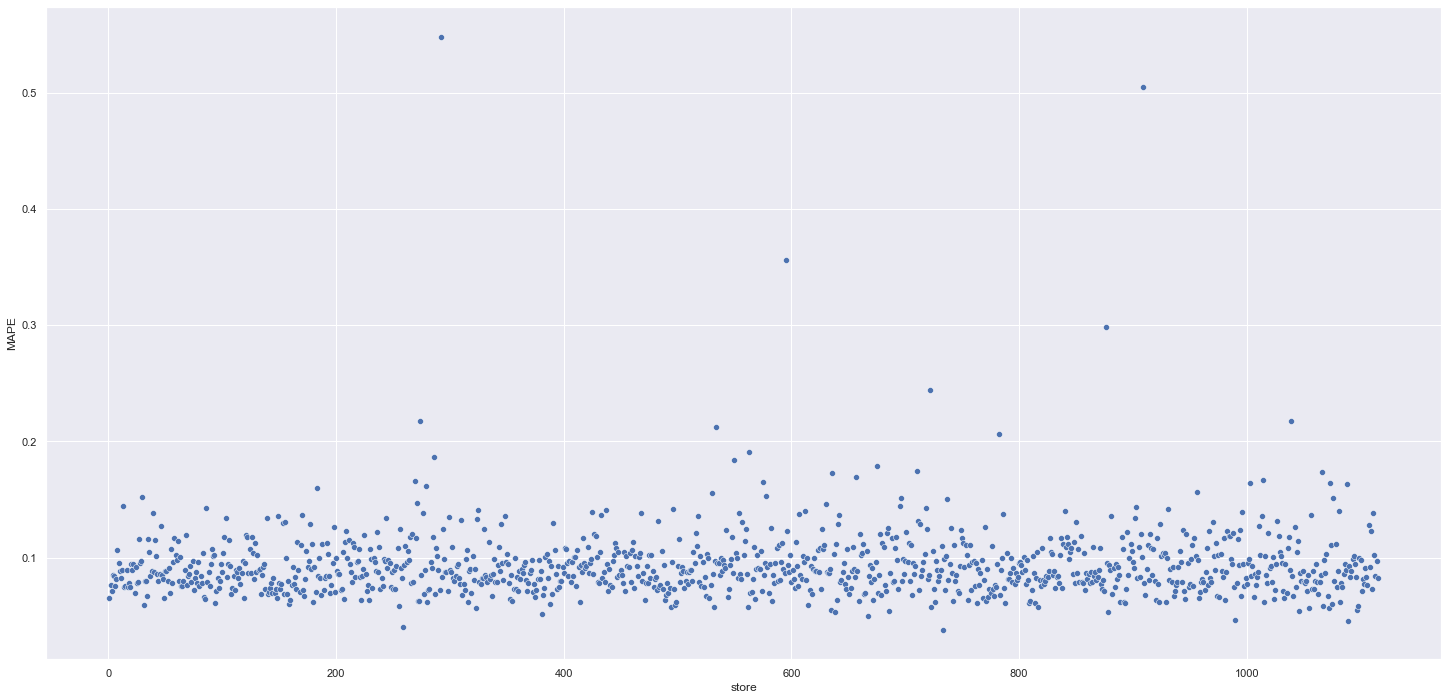

In [111]:
sns.scatterplot(x='store', y='MAPE', data=df92);

## 9.2. Total Performance

In [112]:
df93 = (df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index':'Scenario', 0:'Values'}))
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"R$282,544,960.00"
1,worst_scenario,"R$281,820,354.48"
2,best_scenario,"R$282,544,846.58"


## 9.3. Machine Learning Performance

In [113]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

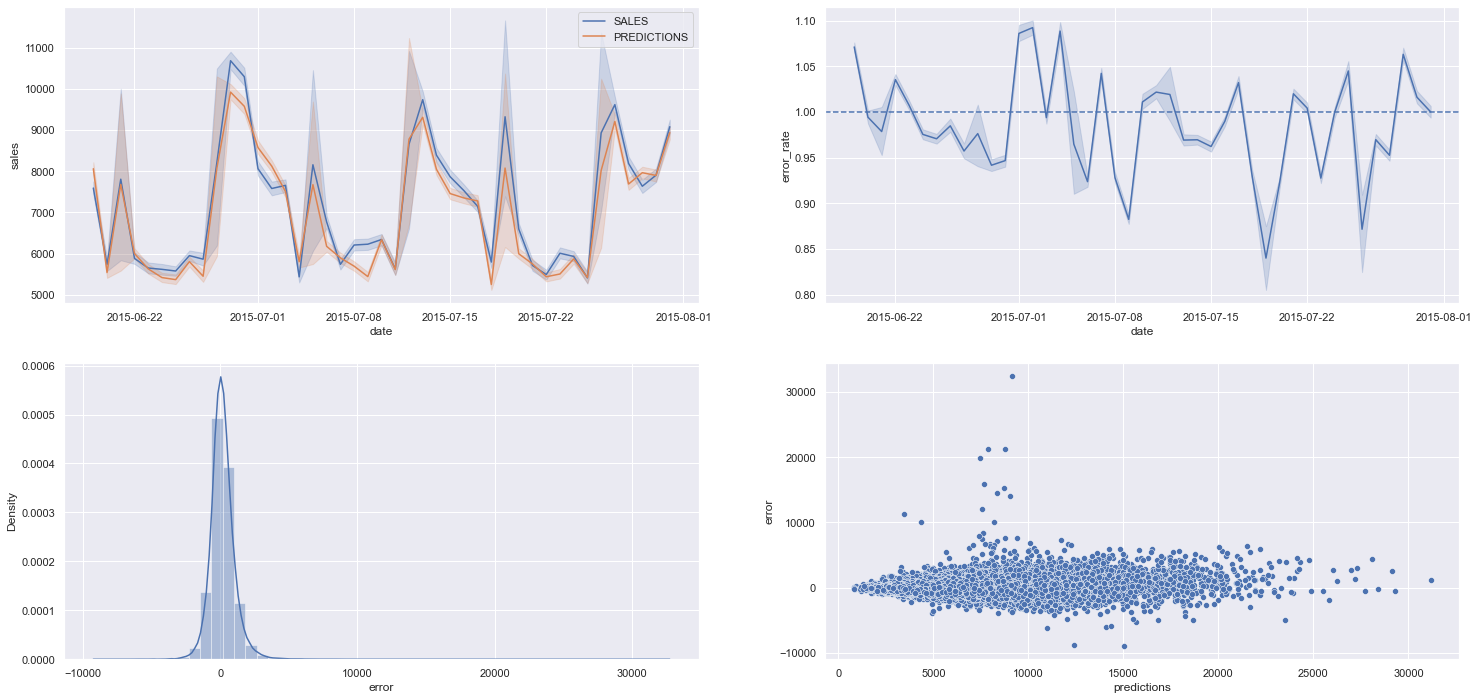

In [114]:
plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')

# OBS: Linestyle mostra a linha do modelo subestimado e superestimado
plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df9)
plt.axhline(1, linestyle='--')

plt.subplot(2, 2, 3)
sns.distplot(df9['error'])

plt.subplot(2, 2, 4)
sns.scatterplot(df9['predictions'], df9['error']);

# 10.0. PASSO 10 - DEPLOY MODEL TO PRODUCTION

In [115]:
# Save Trained Model
pickle.dump(model_xgb_tuned, open(r'C:\\Users\\mlsil\\OneDrive\\Documentos\\repos\\ds_em_producao\\model\\model_rosmann.pkl', 'wb'))

## 10.1. Rossmann Class

In [116]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann(object):
    def __init__(self):
        self.home_path='rC:\\Users\\mlsil\\OneDrive\\Documentos\\repos\\ds_em_producao\\'
        self.competition_distance_scaler   = pickle.load(open(self.home_path + 'parameter\\competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open(self.home_path + 'parameter\\competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler        = pickle.load(open(self.home_path + 'parameter\\promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler                   = pickle.load(open(self.home_path + 'parameter\\year_scaler.pkl', 'rb'))
        self.store_type_scaler             = pickle.load(open(self.home_path + 'parameter\\store_type_scaler.pkl', 'rb'))

    def data_cleaning(self, df1):

        ## 1.1 Rename Columns

        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo','StateHoliday', 
                    'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list(map(snakecase, cols_old))

        # rename
        df1.columns = cols_new

        ## 1.3 Data Types
        df1['date'] = pd.to_datetime(df1['date'])

        ## 1.5 Fillout NA
        # competition_distance / aumentou a distância em 200.000
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x)

        # competition_open_since_month / subistuir o N/A pela data
        df1['competition_open_since_month'] =  df1.apply (lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

        # competition_open_since_year / substituir o N/A pela data
        df1['competition_open_since_year'] =  df1.apply (lambda x: x['date'].year if math.isnan( x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

        # promo2_since_week / substituir o N/A pela data
        df1['promo2_since_week'] =  df1.apply (lambda x: x['date'].week if math.isnan( x['promo2_since_week']) else x['promo2_since_week'], axis=1)

        # promo2_since_year
        df1['promo2_since_year'] =  df1.apply (lambda x: x['date'].year if math.isnan( x['promo2_since_year']) else x['promo2_since_year'], axis=1)

        # promo_interval
        month_map = {1: 'jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Set', 10: 'Out', 11: 'Nov', 12: 'Dec',}

        df1['promo_interval'].fillna(0, inplace=True)

        df1['month_map'] = df1['date'].dt.month.map( month_map )

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['promo_interval'].split( ',' ) else 0, axis=1)

        ## 1.6 Change Types

        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
        
        return df1

    def feature_engineering(self, df2):
        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year Week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1 ), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30).apply( lambda x: x.days ).astype( int )

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else'extra' if x == 'b' else 'extended' )

        # state holiday
        df2['state_holiday'] = (df2['state_holiday'].apply( lambda
                                                           x: 'public_holiday'if x == 'a' else 'easter_holiday' if
                                                            x == 'b' else 'christmas' if x == 'c'else 'regular_day' ))

        # 3.0 PASSO 03 - FILTRAGEM DE VARIÁVEIS
        ## 3.1 Filtragem das linhas


        df2 = df2[df2['open'] !=0]

        ## 3.2 Seleção das colunas

        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis=1)
        
        return df2

    def data_preparation(self, df5):
        
        ## 5.2. Rescaling
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)

        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)
        
        # year
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)
        
        ### 5.3.1. Encoding
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])

        # assortment - Ordinal Encoding
        assortment_dict = {'basic':1, 'extra':2, 'extended':3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        ### 5.3.3. Nature transformation

        # day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

        # week_of_year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))
        
        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 
                        'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month',
                        'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin',
                        'day_cos', 'week_of_year_sin', 'week_of_year_cos']
        
        return df5[cols_selected]
    
    def get_prediction(self, model, original_data, test_data):
        # prediction
        pred = model.predict(test_data)
        
        # join pred into original data
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient='records', date_format='iso')

## 10.2 API Handler

In [117]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load(open(r'C:\\Users\\mlsil\\OneDrive\\Documentos\\repos\\ds_em_producao\\model\\model_rossmann.pkl', 'rb'))

# initialize API
app = Flask(__name__)

@app.route('/rossmann/predict', methods=['POST'])
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance(test_json, dict): # unique example
            test_raw = pd.DataFrame(test_json, index=[0])
            
        else: # multiple example
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
        
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = papeline.data_cleaning(test_raw)
        
        # feature engeneering
        df2 = pipeline.feature_engeneering(df1)
        
        # data preparation
        df3 = pipeline.data_preparation(df2)
        
        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
        
    else: 
        return Response( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run('0.0.0.0')


ModuleNotFoundError: No module named 'rossmann'

## 10.3. API Tester

In [ ]:
# Loading test dataset
df10 = pd.read_csv(r'C:\\Users\\mlsil\\OneDrive\\Documentos\\repos\\ds_em_producao\\csv\\test.csv')

In [ ]:
# merger test dataset + store
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

# choose store for prediction
df_test = df_test[df_test['Store'].isin([24, 12, 22])]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()] # diferença
df_test = df_test.drop('Id', axis=1)

In [ ]:
# convert to DataFrame to json
data = json.dumps(df_test.to_dict(orient='records'))

In [ ]:
# API Call
url = 'http://localhost:5000/rossmann/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post(url, data=data, headers=header)
print('Status Code {}'.format(r.status_code))

In [ ]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [ ]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range(len( d2 )):
    print('Store Number {} will sell R${:,.2f} in the next 6 weeks'.format(d2.loc[i, 'store'], d2.loc[i, 'prediction']))